In [1]:
import pandas as pd
import numpy as np
import pickle
from pprint import pprint

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE, SVMSMOTE, ADASYN

In [2]:
from sqlalchemy import create_engine
import pymysql
import db_connection as dbconn
scam_df = pd.read_parquet('data/parquet_files/account_df_scam_alt.parquet')
train_df = pd.read_parquet('data/parquet_files/account_df_train.parquet')
test_df = pd.read_parquet('data/parquet_files/account_df.parquet')

scam_addresses_in_train_test = pd.read_pickle('data/pickle_files/scam_addresses_in_train_test_alt.pkl')

In [3]:
config_sql = dbconn.config_sql
config_train_sql = dbconn.config_train_sql
config_scam_sql = dbconn.config_scam_sql

engine_sql = create_engine(f"mysql+pymysql://{config_sql['user']}:{config_sql['password']}@{config_sql['host']}:{config_sql['port']}/{config_sql['database']}")
engine_train_sql = create_engine(f"mysql+pymysql://{config_train_sql['user']}:{config_train_sql['password']}@{config_train_sql['host']}:{config_train_sql['port']}/{config_train_sql['database']}")
engine_scam_sql = create_engine(f"mysql+pymysql://{config_scam_sql['user']}:{config_scam_sql['password']}@{config_scam_sql['host']}:{config_scam_sql['port']}/{config_scam_sql['database']}")

address_df = pd.read_sql('SELECT * FROM Addresses', con=engine_sql)
train_address_df = pd.read_sql('SELECT * FROM Addresses', con=engine_train_sql)
scam_address_df = pd.read_sql('SELECT * FROM Addresses', con=engine_scam_sql)

In [4]:
test_df = test_df.merge(address_df, how='left', on='address_id')
train_df = train_df.merge(train_address_df, how='left', on='address_id')

In [14]:
contract_creators_df = pd.read_parquet('data/parquet_files/fraud_contract_creators.parquet')
contract_creator_addresses = contract_creators_df['contract_creator'].tolist()
scam_df_temp = scam_df.merge(scam_address_df, how='left', on='address_id')
scam_df_temp = scam_df_temp[scam_df_temp['address'].isin(contract_creator_addresses)]

contract_creator_addresses_by_id = scam_df_temp['address_id'].unique().tolist()

In [16]:
len(contract_creator_addresses_by_id)

553

In [5]:
train_with_scam_df = train_df.copy()
train_df = train_df[~train_df['address'].isin(scam_addresses_in_train_test)]
dummy_test_df = test_df[~test_df['address'].isin(scam_addresses_in_train_test)]
train_df['year_month'] = '2022-05'
train_with_scam_df['year_month'] = '2022-05'
test_df['year_month'] = '2022-06'
dummy_test_df['year_month'] = '2022-06'

addresses_in_train_test = list(set(train_df['address']).intersection(set(dummy_test_df['address'])))
with open('data/pickle_files/addresses_in_train_test_alt.pkl', 'wb') as f:
    pickle.dump(addresses_in_train_test, f)
all_addresses_in_train_test = list(set(train_with_scam_df['address']).intersection(set(test_df['address'])))

additions_to_train_df = dummy_test_df[dummy_test_df['address'].isin(addresses_in_train_test)]
addtions_to_train_with_scam_df = test_df[test_df['address'].isin(all_addresses_in_train_test)]
test_df = test_df[~test_df['address'].isin(addresses_in_train_test)]
train_df = pd.concat([train_df, additions_to_train_df])
train_with_scam_df = pd.concat([train_with_scam_df, addtions_to_train_with_scam_df])

train_main_df = train_df[~train_df['address'].isin(addresses_in_train_test)]
two_month_df = pd.concat([train_df, test_df])
train_two_month_df = two_month_df[two_month_df['address'].isin(addresses_in_train_test)]
train_two_month_with_scam_df = train_with_scam_df[train_with_scam_df['address'].isin(all_addresses_in_train_test)]

reordered_columns = ['address', 'address_id', 'year_month', 'outgoing_tx_count', 'incoming_tx_count',
                    'unique_received_transactions', 'unique_sent_transactions',
                    'contracts_created', 'total_tx_with_contracts', 'total_incoming_eth',
                    'total_outgoing_eth', 'time_difference_in_minutes',
                    'avg_time_diff_out_minutes', 'avg_time_diff_in_minutes',
                    'total_avg_time_diff_minutes', 'outgoing_erc_20_tnx',
                    'incoming_erc_20_tnx', 'total_erc_20_tnx', 'total_outgoing_erc20eth',
                    'total_incoming_erc20eth', 'min_erc20token_in', 'min_erc20token_out',
                    'max_erc20token_in', 'max_erc20token_out', 'num_unique_erc20tokens_out',
                    'num_unique_erc20tokens_in', 'outgoing_erc_1155_tnx',
                    'incoming_erc_1155_tnx', 'total_erc_1155_tnx', 'outgoing_erc_721_tnx',
                    'incoming_erc_721_tnx', 'total_erc_721_tnx',
                    'num_unique_erc721asset_out', 'num_unique_erc721asset_in',
                    'daily_from_gini_index', 'daily_to_gini_index',
                    'weekly_from_gini_index', 'weekly_to_gini_index',
                    'daily_total_gini_index', 'weekly_total_gini_index',
                    'median_recency_out', 'median_recency_in', 'num_outliers_eth_out',
                    'num_outliers_eth_in']

train_main_df = train_main_df[reordered_columns]
train_two_month_df = train_two_month_df[reordered_columns]
train_two_month_with_scam_df = train_two_month_with_scam_df[reordered_columns]
test_df = test_df[reordered_columns]

train_main_df.to_parquet('data/parquet_files/train_main_df.parquet')
train_two_month_df.to_parquet('data/parquet_files/train_two_month_df.parquet')
train_two_month_with_scam_df.to_parquet('data/parquet_files/train_two_month_with_scam_df.parquet')
test_df.to_parquet('data/parquet_files/test_df.parquet')

/var/folders/xs/x2x4yg29089c8t_v4z9nymz40000gn/T/ipykernel_53423/619642566.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dummy_test_df['year_month'] = '2022-06'


In [6]:
scam_df = pd.read_parquet('data/parquet_files/account_df_scam.parquet')
train_main_df = pd.read_parquet('data/parquet_files/train_main_df.parquet')
train_two_month_df = pd.read_parquet('data/parquet_files/train_two_month_df.parquet')
scam_df.shape
# test_df = pd.read_parquet('data/parquet_files/test_df.parquet')

(26933, 43)

In [18]:
scam_df = scam_df[~scam_df['address_id'].isin(contract_creator_addresses_by_id)]
print(scam_df.shape)

(24223, 43)


In [7]:
from random import sample
from math import floor

from alchemy_api import AlchemyApi
import pandas as pd
import numpy as np

import random
from web3 import Web3

import concurrent.futures
import re

train_main_candidate_addresses = train_main_df['address'].sample(n=floor(len(scam_df)*1.5), random_state=42)
unique_addresses_two_month_addresses = pd.Series(train_two_month_df['address'].unique())
train_two_month_candidate_addresses = unique_addresses_two_month_addresses.sample(n=floor(1.5*len(scam_df)/2), random_state=42)
addresses_to_verify = train_main_candidate_addresses.tolist() + train_two_month_candidate_addresses.tolist()

alchemy = AlchemyApi()

def get_address_type(address, api_keys, alchemy_url):
    check_sum_address = Web3.to_checksum_address(address)
    api_key = api_key_rotation(api_keys)
    full_url = alchemy_url + api_key
    w3 = Web3(Web3.HTTPProvider(full_url))
    response = w3.eth.get_code(check_sum_address)
    return response.hex() == '0x'

def api_key_rotation(api_keys):
    index = random.randint(0, len(api_keys) - 1)
    return api_keys[index]

user_addresses = []
contract_addresses = []
api_keys = alchemy.get_api_keys()
alchemy_url = alchemy.get_api_url()

with concurrent.futures.ThreadPoolExecutor(max_workers=6) as executor:
    future_to_address = {executor.submit(get_address_type, address, api_keys, alchemy_url): address for address in addresses_to_verify}
    for future in concurrent.futures.as_completed(future_to_address):
        address = future_to_address[future]
        try:
            is_user_address = future.result()
            if is_user_address:
                user_addresses.append(address)
            else:
                contract_addresses.append(address)
        except TypeError as e:
            continue

In [8]:
with open('data/pickle_files/training_user_addresses_filtered.pickle', 'wb') as f:
    pickle.dump(user_addresses, f)

with open('data/pickle_files/training_contract_addresses_filtered.pickle', 'wb') as f:
    pickle.dump(contract_addresses, f)

In [9]:
user_addresses = pd.read_pickle('data/pickle_files/training_user_addresses_filtered.pickle')
contract_addresses = pd.read_pickle('data/pickle_files/training_contract_addresses_filtered.pickle')

print(len(user_addresses))
print(len(contract_addresses))
train_main_candidate_df = train_main_df[train_main_df['address'].isin(user_addresses)]
train_two_month_candidate_addresses = train_two_month_candidate_addresses[train_two_month_candidate_addresses.isin(user_addresses)]

train_main_sub_df = train_main_candidate_df.sample(n=len(scam_df), random_state=42)
two_month_addresses = train_two_month_candidate_addresses.sample(n=floor(len(scam_df)/2), random_state=42)
print(len(two_month_addresses))
print(len(two_month_addresses.unique()))
train_two_month_sub_df = train_two_month_df[train_two_month_df['address'].isin(two_month_addresses)]

print(len(train_main_sub_df))
print(len(train_two_month_sub_df))

57675
2923
13466
13466
26933
26932


In [11]:
# from math import floor
# train_main_sub_df = train_main_df.sample(n=len(scam_df), random_state=42)
# unique_addresses_two_month_addresses = pd.Series(train_two_month_df['address'].unique())
# two_month_addresses = unique_addresses_two_month_addresses.sample(n=floor(len(scam_df)/2), random_state=42)
# train_two_month_sub_df = train_two_month_df[train_two_month_df['address'].isin(two_month_addresses)]

# print(len(train_main_sub_df))
# print(len(train_two_month_sub_df))

26653
26652


In [10]:
train_main_sub_df['Flag'] = 0
train_two_month_sub_df['Flag'] = 0
scam_df['Flag'] = 1

/var/folders/xs/x2x4yg29089c8t_v4z9nymz40000gn/T/ipykernel_53423/3764886436.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_two_month_sub_df['Flag'] = 0


In [11]:
train_main_df = pd.read_parquet('data/parquet_files/train_main_df.parquet')
train_two_month_df = pd.read_parquet('data/parquet_files/train_two_month_df.parquet')

In [12]:
training_scam_data = pd.concat([train_main_sub_df, train_two_month_sub_df, scam_df]).reset_index(drop=True)
training_scam_data.to_parquet('data/parquet_files/training_scam_data.parquet')

In [2]:
from math import ceil, floor
training_scam_data = pd.read_parquet('data/parquet_files/training_scam_data_alt.parquet')

#downsample non-fraud addresses
non_fraud_addresses = training_scam_data[training_scam_data['Flag'] == 0]
non_fraud_address_counts = non_fraud_addresses['address'].value_counts()
num_fraud = training_scam_data[training_scam_data['Flag'] == 1].shape[0]
random_may_addresses = non_fraud_address_counts[non_fraud_address_counts == 1].sample(n=ceil(num_fraud/2), random_state=42)
random_may_june_addresses = non_fraud_address_counts[non_fraud_address_counts >= 2].sample(n=floor(num_fraud/4), random_state=42)
random_may_addresses_list = random_may_addresses.index.tolist()
random_may_june_addresses_list = random_may_june_addresses.index.to_list()
scam_addresses = training_scam_data[training_scam_data['Flag'] == 1]['address'].unique().tolist()
sampled_addresses = random_may_addresses_list + random_may_june_addresses_list + scam_addresses
training_scam_data_balanced = training_scam_data[training_scam_data['address'].isin(sampled_addresses)]

training_scam_data.drop(columns=['address', 'address_id', 'year_month'], inplace=True)
training_scam_data_balanced.drop(columns=['address', 'address_id', 'year_month'], inplace=True)

/var/folders/xs/x2x4yg29089c8t_v4z9nymz40000gn/T/ipykernel_91937/927739476.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_scam_data_balanced.drop(columns=['address', 'address_id', 'year_month'], inplace=True)


In [113]:
summary_stats = training_scam_data.describe()
skewness = training_scam_data.skew()
kurtosis = training_scam_data.kurt()
summary_stats = summary_stats.append(skewness.rename('skew'))
summary_stats = summary_stats.append(kurtosis.rename('kurt'))

display(summary_stats)

/Users/nat_rng/opt/anaconda3/envs/py38/lib/python3.8/site-packages/pandas/core/nanops.py:1214: RuntimeWarning: overflow encountered in multiply
  adjusted3 = adjusted2 * adjusted
/Users/nat_rng/opt/anaconda3/envs/py38/lib/python3.8/site-packages/pandas/core/nanops.py:1213: RuntimeWarning: overflow encountered in square
  adjusted2 = adjusted**2
/Users/nat_rng/opt/anaconda3/envs/py38/lib/python3.8/site-packages/pandas/core/nanops.py:1302: RuntimeWarning: overflow encountered in square
  adjusted4 = adjusted2**2
/Users/nat_rng/opt/anaconda3/envs/py38/lib/python3.8/site-packages/pandas/core/nanops.py:1301: RuntimeWarning: overflow encountered in square
  adjusted2 = adjusted**2
/var/folders/xs/x2x4yg29089c8t_v4z9nymz40000gn/T/ipykernel_58391/3648145958.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_stats = summary_stats.append(skewness.rename('skew'))
/var/folders/xs/x2x4yg29089c8t_v4z9ny

,outgoing_tx_count,incoming_tx_count,unique_received_transactions,unique_sent_transactions,contracts_created,total_tx_with_contracts,total_incoming_eth,total_outgoing_eth,time_difference_in_minutes,avg_time_diff_out_minutes,...,daily_to_gini_index,weekly_from_gini_index,weekly_to_gini_index,daily_total_gini_index,weekly_total_gini_index,median_recency_out,median_recency_in,num_outliers_eth_out,num_outliers_eth_in,Flag
count,7.995800e+04,7.995800e+04,79958.000000,79958.000000,79958.000000,7.995800e+04,7.995800e+04,79958.000000,79958.000000,79958.000000,...,66106.000000,54417.000000,66106.000000,79958.000000,79958.000000,79958.000000,79958.000000,68470.000000,6.847000e+04,79958.000000
mean,7.769798e+01,6.287317e+01,25.004590,22.938868,0.011906,1.405831e+02,1.307529e+02,109.080492,9003.426432,1164.196470,...,0.925763,0.659665,0.645992,0.924165,0.647173,0.269356,0.253476,27.974558,1.110522e+02,0.333338
std,6.641804e+03,5.529386e+03,2036.254333,1642.940402,0.448293,1.210535e+04,6.347133e+03,5519.531302,13535.391936,3605.913477,...,0.087830,0.157126,0.169664,0.090008,0.164512,0.387460,0.367770,2212.021956,1.467078e+04,0.471409
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.053758,0.000000,0.000000,0.051070,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,0.000000e+00,1.000000e+00,1.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.933333,0.583333,0.550000,0.926667,0.563782,0.000000,0.000000,0.000000,0.000000e+00,0.000000
50%,1.000000e+00,1.000000e+00,1.000000,1.000000,0.000000,3.000000e+00,7.000000e-03,0.000660,49.400000,0.000000,...,0.966667,0.750000,0.750000,0.966667,0.750000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
75%,3.000000e+00,3.000000e+00,2.000000,2.000000,0.000000,7.000000e+00,3.318725e-01,0.300008,15987.320833,201.834944,...,0.966667,0.750000,0.750000,0.966667,0.750000,0.500000,0.499392,0.000000,0.000000e+00,1.000000
max,1.307578e+06,1.115378e+06,404508.000000,234661.000000,101.000000,2.422956e+06,1.038828e+06,853242.331772,44698.500000,42977.183333,...,0.966667,0.776168,0.776563,0.966667,0.773931,1.000000,1.000000,339024.000000,3.620739e+06,1.000000
skew,1.472554e+02,1.567448e+02,151.796349,114.071182,155.987153,1.529988e+02,1.119974e+02,119.817415,1.283806,5.304676,...,-3.905965,-1.721124,-1.577230,-3.836050,-1.547783,0.993273,1.086615,114.735106,2.234446e+02,0.707100
kurt,2.477139e+04,2.734161e+04,26008.935279,14214.276917,32901.244827,2.640047e+04,1.488678e+04,16326.064464,0.182238,35.587611,...,19.739128,2.079880,1.586868,18.841923,1.477688,-0.701497,-0.436655,14977.479688,5.433539e+04,-1.500047


In [116]:
#split summary stats table in half column wise
summary_stats_t = summary_stats.T
mid_idx = len(summary_stats_t.columns) // 2

summary_stats_1 = summary_stats_t.iloc[:, :mid_idx]
summary_stats_2 = summary_stats_t.iloc[:, mid_idx:]
summary_stats_1 = summary_stats_1.round(2)
summary_stats_2 = summary_stats_2.round(2)

summary_stats_1.to_latex('summary_stats_1.tex')
summary_stats_2.to_latex('summary_stats_2.tex')
summary_stats_2

/var/folders/xs/x2x4yg29089c8t_v4z9nymz40000gn/T/ipykernel_58391/864120797.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  summary_stats_1.to_latex('summary_stats_1.tex')
/var/folders/xs/x2x4yg29089c8t_v4z9nymz40000gn/T/ipykernel_58391/864120797.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  summary_stats_2.to_latex('summary_stats_2.tex')


,50%,75%,max,skew,kurt
outgoing_tx_count,1.00,3.00,1.307578e+06,147.26,24771.39
incoming_tx_count,1.00,3.00,1.115378e+06,156.74,27341.61
unique_received_transactions,1.00,2.00,4.045080e+05,151.80,26008.94
unique_sent_transactions,1.00,2.00,2.346610e+05,114.07,14214.28
contracts_created,0.00,0.00,1.010000e+02,155.99,32901.24
total_tx_with_contracts,3.00,7.00,2.422956e+06,153.00,26400.47
total_incoming_eth,0.01,0.33,1.038828e+06,112.00,14886.78
total_outgoing_eth,0.00,0.30,8.532423e+05,119.82,16326.06
time_difference_in_minutes,49.40,15987.32,4.469850e+04,1.28,0.18
avg_time_diff_out_minutes,0.00,201.83,4.297718e+04,5.30,35.59


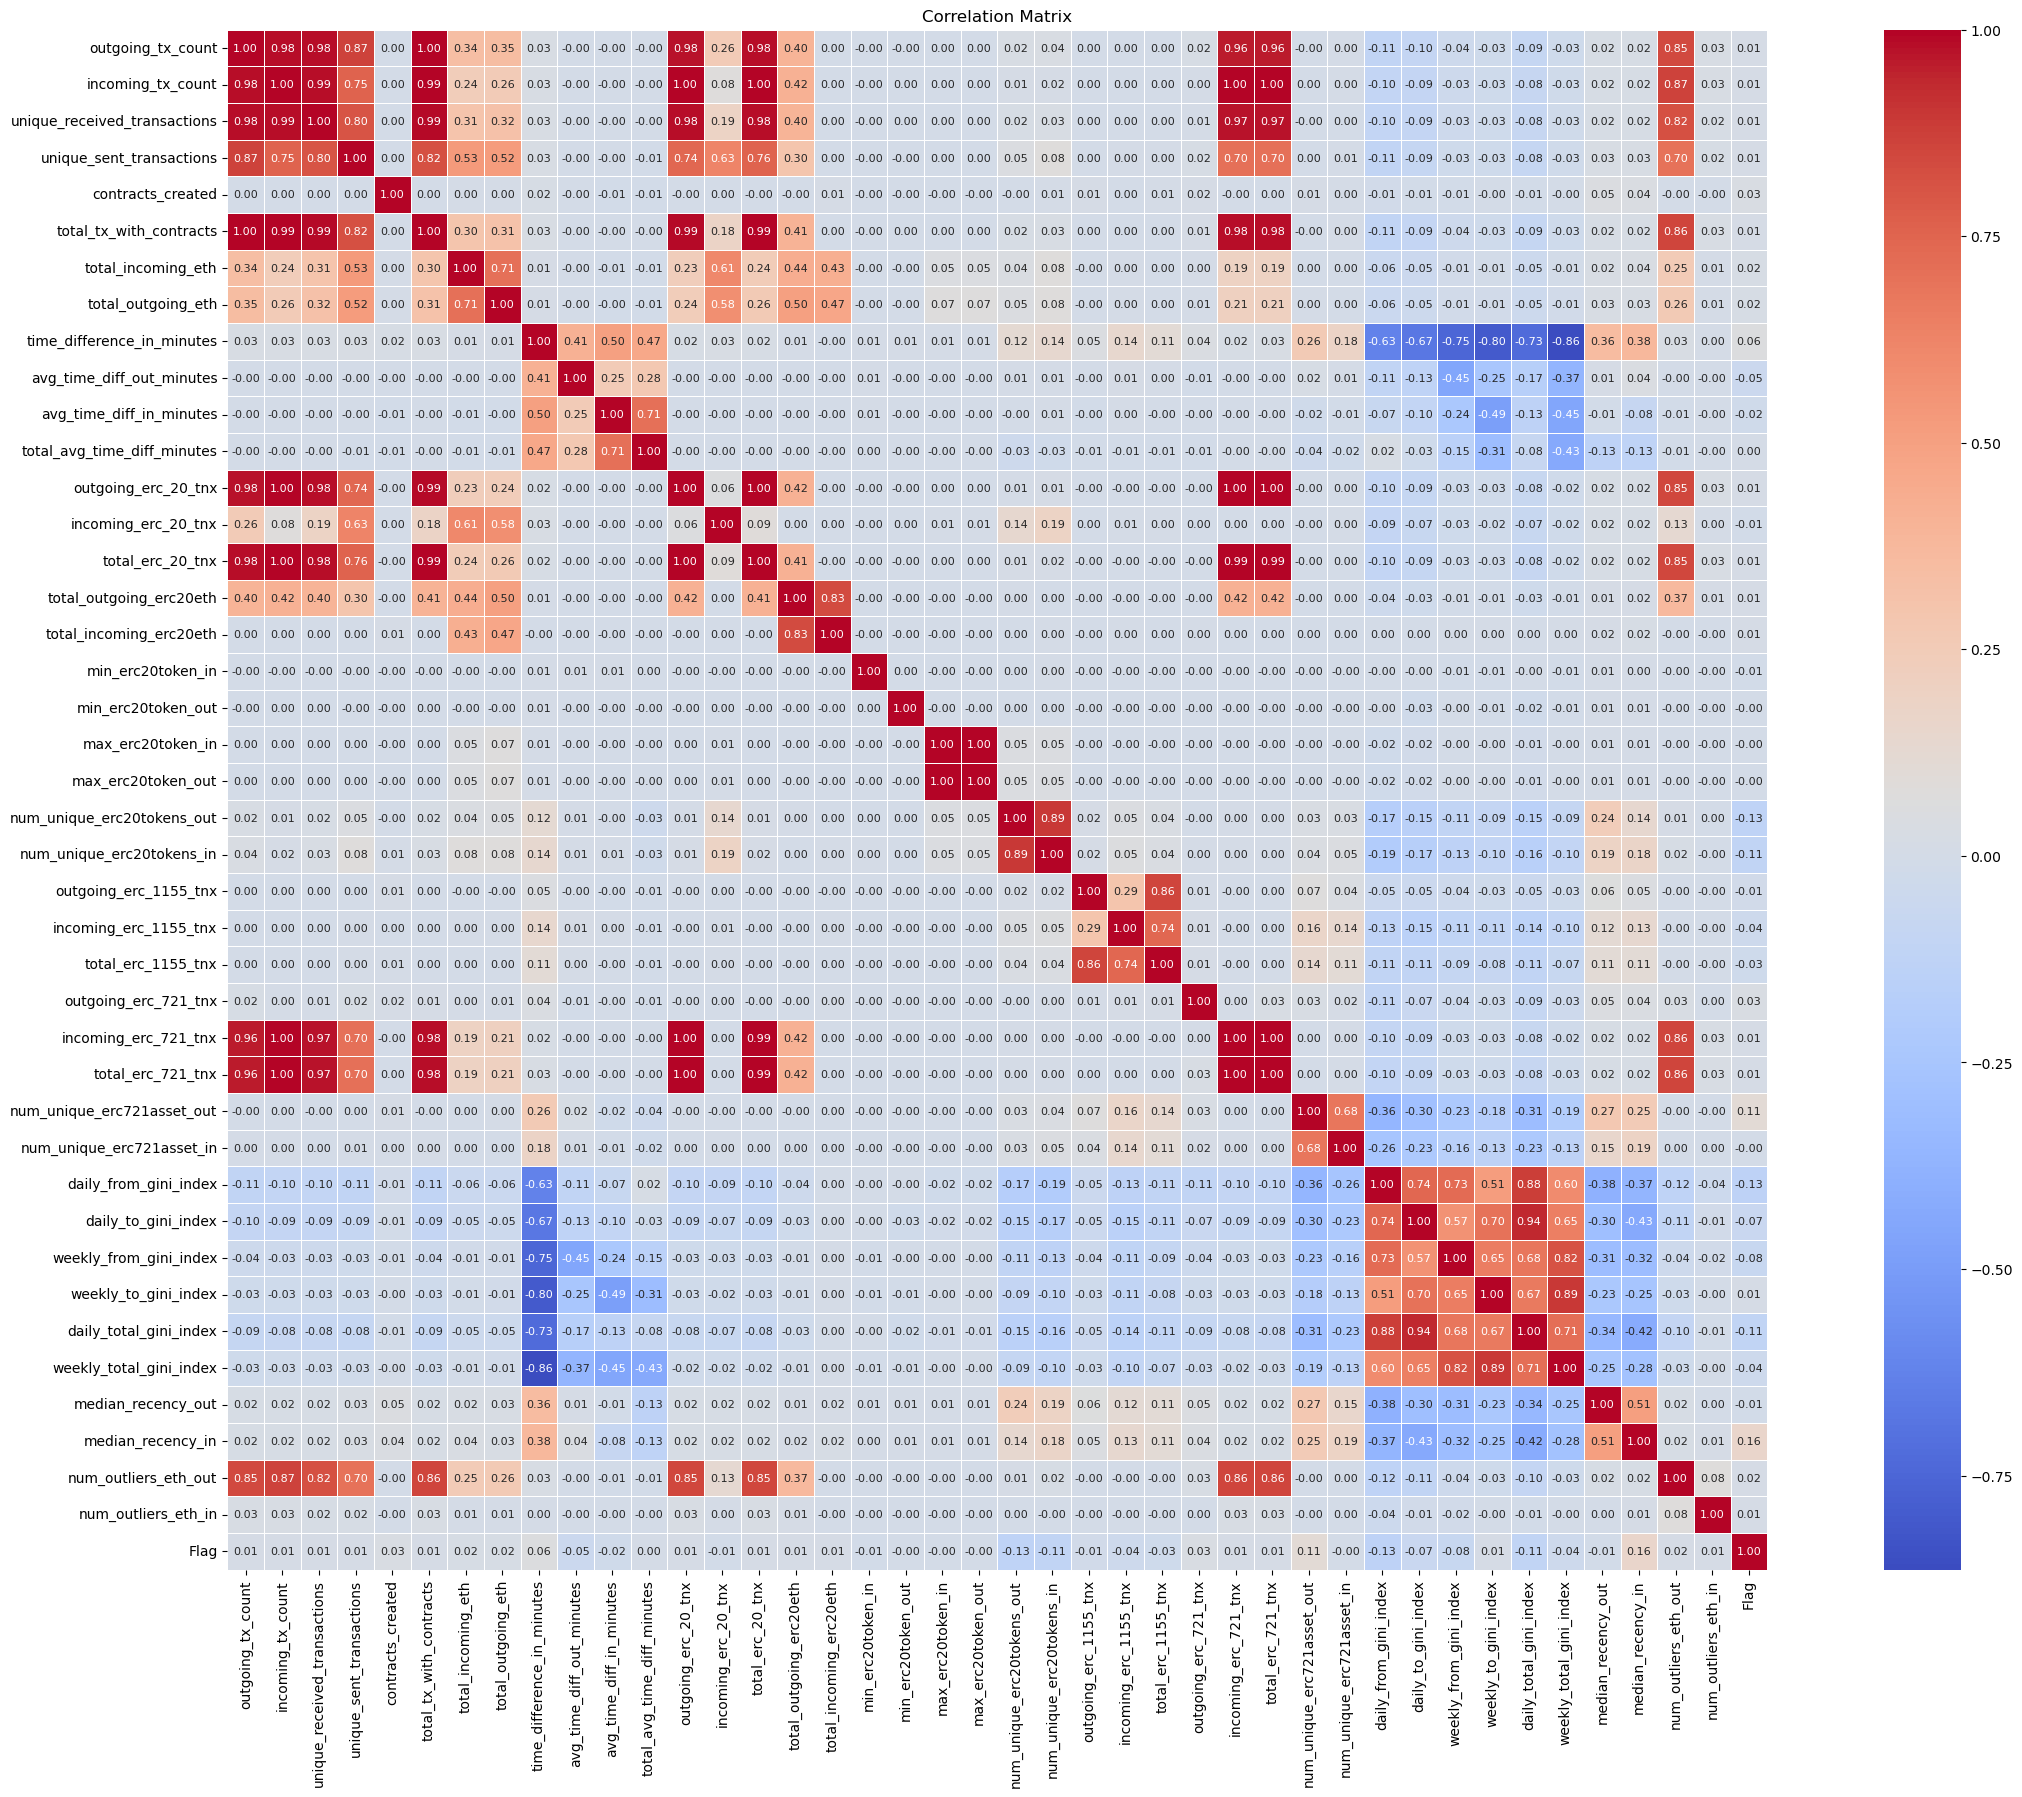

In [5]:
correlation_matrix = training_scam_data.corr()

plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=.5, annot_kws={'size': 8})
plt.title("Correlation Matrix")
plt.show()

In [9]:
upper_half = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

high_corr = [column for column in upper_half.columns if any(upper_half[column].abs() > 0.8)]

correlated_pairs = []
for column in high_corr:
    correlated_pairs.extend([(column, row) for row in upper_half.index[upper_half[column].abs() > 0.8]])

pprint(correlated_pairs)

[('incoming_tx_count', 'outgoing_tx_count'),
 ('unique_received_transactions', 'outgoing_tx_count'),
 ('unique_received_transactions', 'incoming_tx_count'),
 ('unique_sent_transactions', 'outgoing_tx_count'),
 ('unique_sent_transactions', 'unique_received_transactions'),
 ('total_tx_with_contracts', 'outgoing_tx_count'),
 ('total_tx_with_contracts', 'incoming_tx_count'),
 ('total_tx_with_contracts', 'unique_received_transactions'),
 ('total_tx_with_contracts', 'unique_sent_transactions'),
 ('outgoing_erc_20_tnx', 'outgoing_tx_count'),
 ('outgoing_erc_20_tnx', 'incoming_tx_count'),
 ('outgoing_erc_20_tnx', 'unique_received_transactions'),
 ('outgoing_erc_20_tnx', 'total_tx_with_contracts'),
 ('total_erc_20_tnx', 'outgoing_tx_count'),
 ('total_erc_20_tnx', 'incoming_tx_count'),
 ('total_erc_20_tnx', 'unique_received_transactions'),
 ('total_erc_20_tnx', 'total_tx_with_contracts'),
 ('total_erc_20_tnx', 'outgoing_erc_20_tnx'),
 ('total_incoming_erc20eth', 'total_outgoing_erc20eth'),
 ('ma

In [7]:
training_scam_data.columns

Index(['outgoing_tx_count', 'incoming_tx_count',
       'unique_received_transactions', 'unique_sent_transactions',
       'contracts_created', 'total_tx_with_contracts', 'total_incoming_eth',
       'total_outgoing_eth', 'time_difference_in_minutes',
       'avg_time_diff_out_minutes', 'avg_time_diff_in_minutes',
       'total_avg_time_diff_minutes', 'outgoing_erc_20_tnx',
       'incoming_erc_20_tnx', 'total_erc_20_tnx', 'total_outgoing_erc20eth',
       'total_incoming_erc20eth', 'min_erc20token_in', 'min_erc20token_out',
       'max_erc20token_in', 'max_erc20token_out', 'num_unique_erc20tokens_out',
       'num_unique_erc20tokens_in', 'outgoing_erc_1155_tnx',
       'incoming_erc_1155_tnx', 'total_erc_1155_tnx', 'outgoing_erc_721_tnx',
       'incoming_erc_721_tnx', 'total_erc_721_tnx',
       'num_unique_erc721asset_out', 'num_unique_erc721asset_in',
       'daily_from_gini_index', 'daily_to_gini_index',
       'weekly_from_gini_index', 'weekly_to_gini_index',
       'daily_total_

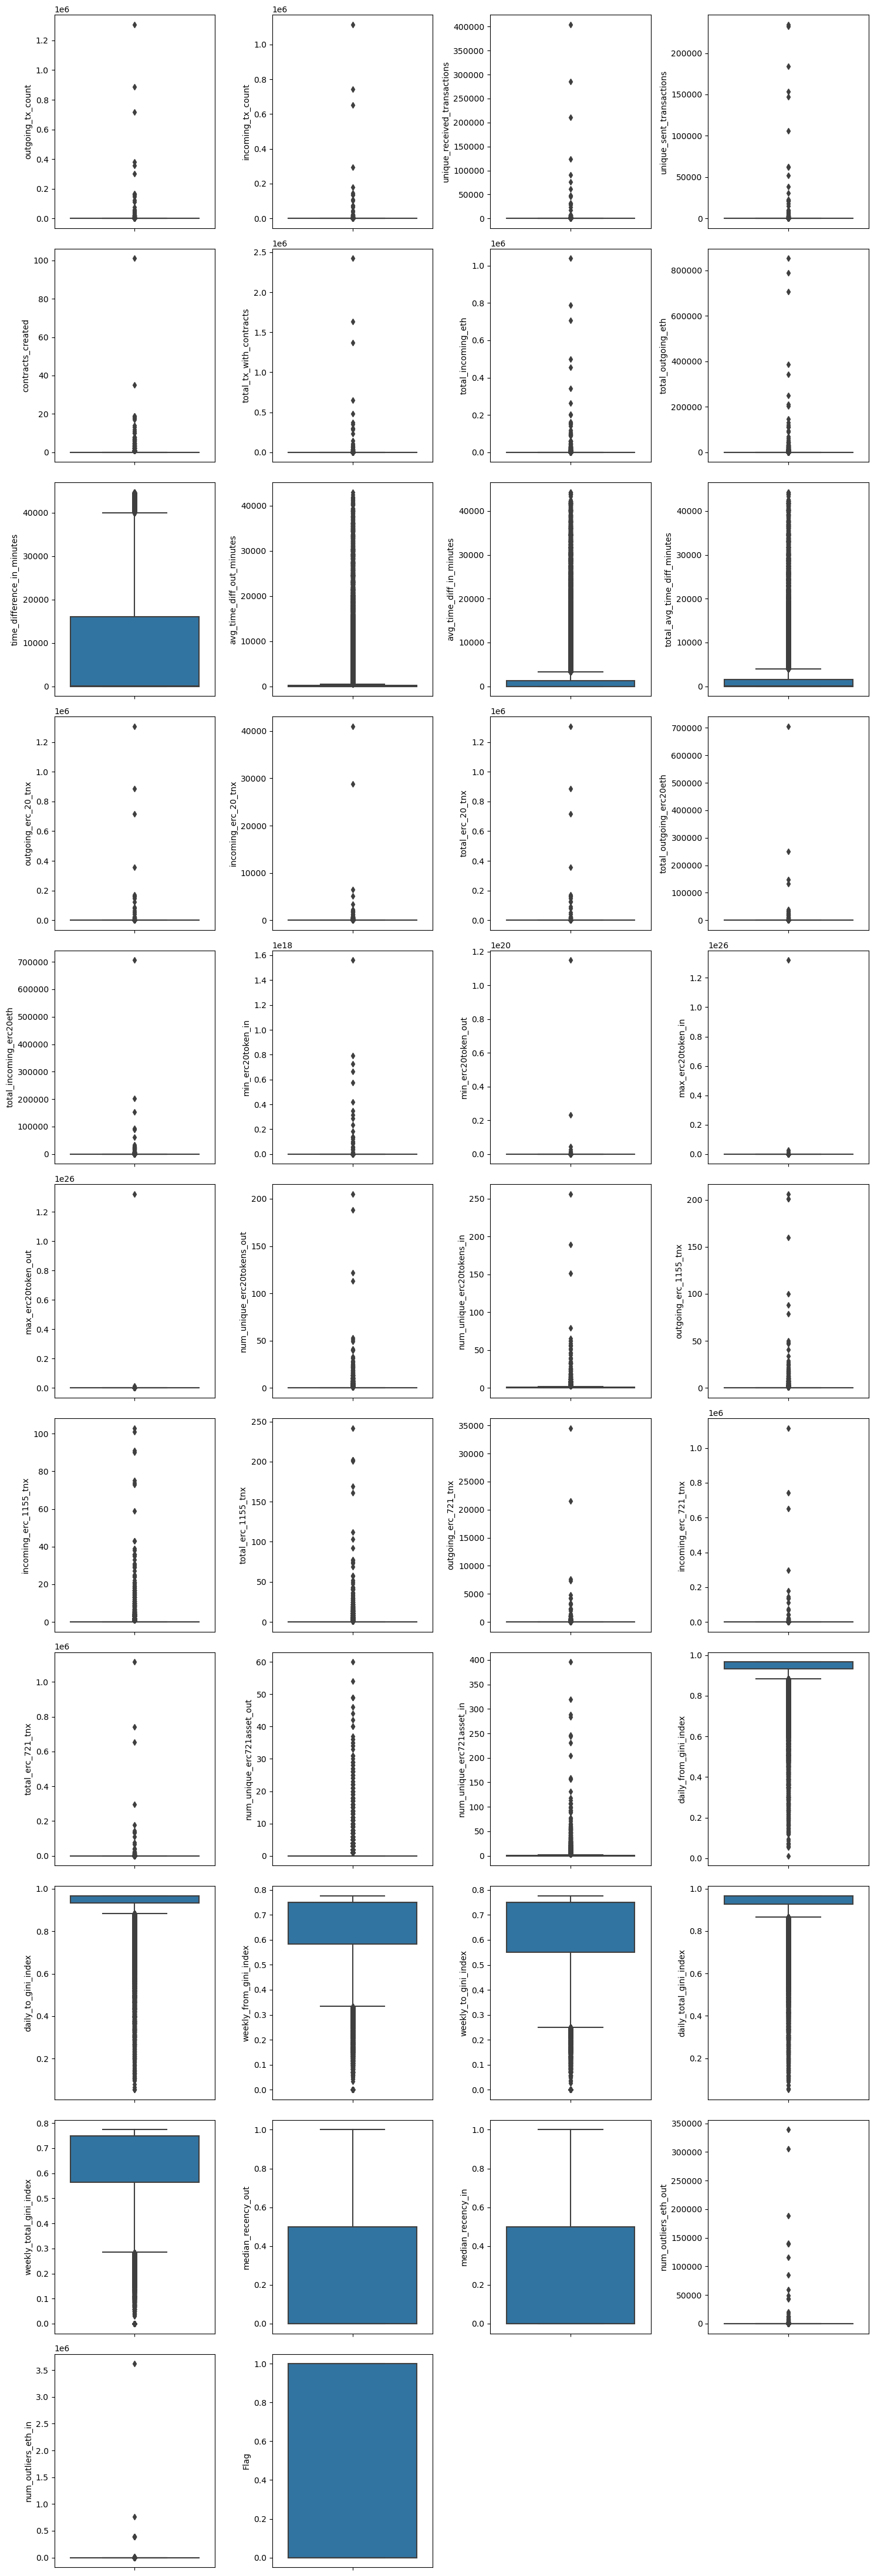

In [10]:
n_cols = 4

n_rows = len(training_scam_data.columns) // n_cols
if len(training_scam_data.columns) % n_cols != 0:
    n_rows += 1

fig = plt.figure(figsize=(15, 4*n_rows))

for i, column in enumerate(training_scam_data.columns):
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    sns.boxplot(y=column, data=training_scam_data, ax=ax)

plt.tight_layout()
plt.show()

In [4]:
# [('incoming_tx_count*', 'outgoing_tx_count*'), ('unique_received_transactions*', 'outgoing_tx_count*'), 
#  ('unique_received_transactions', 'incoming_tx_count*'), ('unique_sent_transactions*', 'outgoing_tx_count*'), 
#  ('unique_sent_transactions*', 'unique_received_transactions*'), ('total_tx_with_contracts', 'outgoing_tx_count*'), 
#  ('total_tx_with_contracts', 'incoming_tx_count*'), ('total_tx_with_contracts', 'unique_received_transactions*'), 
#  ('total_tx_with_contracts', 'unique_sent_transactions*'), ('outgoing_erc_20_tnx*', 'outgoing_tx_count'),
#  ('outgoing_erc_20_tnx*', 'incoming_tx_count'), ('outgoing_erc_20_tnx*', 'unique_received_transactions*'), 
#  ('outgoing_erc_20_tnx*', 'total_tx_with_contracts'), ('total_erc_20_tnx*', 'outgoing_tx_count*'), 
#  ('total_erc_20_tnx*', 'incoming_tx_count*'), ('total_erc_20_tnx*', 'unique_received_transactions*'), 
#  ('total_erc_20_tnx*', 'total_tx_with_contracts'), ('total_erc_20_tnx*', 'outgoing_erc_20_tnx'), 
#  ('total_incoming_erc20eth', 'total_outgoing_erc20eth*'), ('max_erc20token_out', 'max_erc20token_in*'), 
#  ('num_unique_erc20tokens_in', 'num_unique_erc20tokens_out*'), ('total_erc_1155_tnx*', 'outgoing_erc_1155_tnx'), 
#  ('incoming_erc_721_tnx*', 'outgoing_tx_count*'), ('incoming_erc_721_tnx*', 'incoming_tx_count*'), 
#  ('incoming_erc_721_tnx*', 'unique_received_transactions*'), ('incoming_erc_721_tnx*', 'total_tx_with_contracts'), 
#  ('incoming_erc_721_tnx*', 'outgoing_erc_20_tnx*'), ('incoming_erc_721_tnx*', 'total_erc_20_tnx*'), 
#  ('total_erc_721_tnx', 'outgoing_tx_count*'), ('total_erc_721_tnx', 'incoming_tx_count*'), 
#  ('total_erc_721_tnx', 'unique_received_transactions*'), ('total_erc_721_tnx', 'total_tx_with_contracts'), 
#  ('total_erc_721_tnx', 'outgoing_erc_20_tnx*'), ('total_erc_721_tnx', 'total_erc_20_tnx*'), 
#  ('total_erc_721_tnx', 'incoming_erc_721_tnx*'), ('weekly_to_gini_index', 'time_difference_in_minutes*'), 
#  ('daily_total_gini_index', 'daily_from_gini_index*'), ('daily_total_gini_index', 'daily_to_gini_index*'), 
#  ('weekly_total_gini_index', 'time_difference_in_minutes*'), ('weekly_total_gini_index', 'weekly_from_gini_index*'), 
#  ('weekly_total_gini_index', 'weekly_to_gini_index*'), ('num_outliers_eth_out', 'outgoing_tx_count*'), 
#  ('num_outliers_eth_out', 'incoming_tx_count*'), ('num_outliers_eth_out', 'unique_received_transactions*'), 
#  ('num_outliers_eth_out', 'total_tx_with_contracts'), ('num_outliers_eth_out', 'outgoing_erc_20_tnx'), 
#  ('num_outliers_eth_out', 'total_erc_20_tnx*'), ('num_outliers_eth_out', 'incoming_erc_721_tnx*'), 
#  ('num_outliers_eth_out', 'total_erc_721_tnx')]

training_data_rfm = training_scam_data[['contracts_created', 'total_tx_with_contracts', 'total_incoming_eth',  
                                        'total_outgoing_eth','avg_time_diff_out_minutes', 'avg_time_diff_in_minutes',
                                        'total_avg_time_diff_minutes', 'incoming_erc_20_tnx', 'total_erc_20_tnx',
                                        'total_incoming_erc20eth', 'min_erc20token_in', 'min_erc20token_out',
                                        'max_erc20token_out', 'num_unique_erc20tokens_in', 'outgoing_erc_1155_tnx',
                                        'incoming_erc_1155_tnx', 'outgoing_erc_721_tnx', 'total_erc_721_tnx',
                                        'num_unique_erc721asset_out', 'num_unique_erc721asset_in', 'daily_total_gini_index', 
                                        'weekly_total_gini_index', 'median_recency_out', 'median_recency_in', 
                                        'num_outliers_eth_out', 'num_outliers_eth_in', 'Flag']]

training_data_rfm_balanced = training_scam_data_balanced[['contracts_created', 'total_tx_with_contracts', 'total_incoming_eth',  
                                                        'total_outgoing_eth','avg_time_diff_out_minutes', 'avg_time_diff_in_minutes',
                                                        'total_avg_time_diff_minutes', 'incoming_erc_20_tnx', 'total_erc_20_tnx',
                                                        'total_incoming_erc20eth', 'min_erc20token_in', 'min_erc20token_out',
                                                        'max_erc20token_out', 'num_unique_erc20tokens_in', 'outgoing_erc_1155_tnx',
                                                        'incoming_erc_1155_tnx', 'outgoing_erc_721_tnx', 'total_erc_721_tnx',
                                                        'num_unique_erc721asset_out', 'num_unique_erc721asset_in', 'daily_total_gini_index', 
                                                        'weekly_total_gini_index', 'median_recency_out', 'median_recency_in', 
                                                        'num_outliers_eth_out', 'num_outliers_eth_in', 'Flag']]

fill_values = {'median_recency_out':0, 'median_recency_in':0, 'num_outliers_eth_out':0, 'num_outliers_eth_in': 0,
               'daily_from_gini_index': -1, 'daily_to_gini_index': -1, 'weekly_from_gini_index': -1, 
               'weekly_to_gini_index': -1, 'daily_total_gini_index': -1, 'weekly_total_gini_index': -1}

training_data_rfm = training_data_rfm.fillna(fill_values)
training_data_rfm_balanced = training_data_rfm_balanced.fillna(fill_values)
training_data_rfm.to_parquet('data/parquet_files/training_data_rfm_alt.parquet')
training_data_rfm_balanced.to_parquet('data/parquet_files/training_data_rfm_balanced_alt.parquet')

In [118]:
removed_features = [feature for feature in training_scam_data.columns if feature not in training_data_rfm.columns]
training_data_rfm.columns

Index(['contracts_created', 'total_tx_with_contracts', 'total_incoming_eth',
       'total_outgoing_eth', 'avg_time_diff_out_minutes',
       'avg_time_diff_in_minutes', 'total_avg_time_diff_minutes',
       'incoming_erc_20_tnx', 'total_erc_20_tnx', 'total_incoming_erc20eth',
       'min_erc20token_in', 'min_erc20token_out', 'max_erc20token_out',
       'num_unique_erc20tokens_in', 'outgoing_erc_1155_tnx',
       'incoming_erc_1155_tnx', 'outgoing_erc_721_tnx', 'total_erc_721_tnx',
       'num_unique_erc721asset_out', 'num_unique_erc721asset_in',
       'daily_total_gini_index', 'weekly_total_gini_index',
       'median_recency_out', 'median_recency_in', 'num_outliers_eth_out',
       'num_outliers_eth_in', 'Flag'],
      dtype='object')

In [4]:
scoring = {'accuracy': make_scorer(accuracy_score), 
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score)}

rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)

In [16]:
X_train_rfm, X_test_rfm, y_train_rfm, y_test_rfm = train_test_split(training_data_rfm.drop(columns=['Flag']), training_data_rfm['Flag'], test_size=0.2, random_state=42)
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)

pt = PowerTransformer()
X_train_rfm_scaled = pt.fit_transform(X_train_rfm)

lr = LogisticRegression(max_iter=1000)
scores_lr = cross_validate(lr, X_train_rfm_scaled, y_train_rfm, cv=rskf, scoring=scoring)

rf = RandomForestClassifier()
scores_rf = cross_validate(rf, X_train_rfm_scaled, y_train_rfm, cv=rskf, scoring=scoring)

xgb = XGBClassifier()
scores_xgb = cross_validate(xgb, X_train_rfm_scaled, y_train_rfm, cv=rskf, scoring=scoring)

rfm_scores_data = {
    'Model': ['LR_RFM', 'RF_RFM', 'XGB_RFM'],
    'Accuracy': [scores_lr["test_accuracy"].mean(), scores_rf["test_accuracy"].mean(), scores_xgb["test_accuracy"].mean()],
    'Precision': [scores_lr["test_precision"].mean(), scores_rf["test_precision"].mean(), scores_xgb["test_precision"].mean()],
    'Recall': [scores_lr["test_recall"].mean(), scores_rf["test_recall"].mean(), scores_xgb["test_recall"].mean()],
    'F1': [scores_lr["test_f1"].mean(), scores_rf["test_f1"].mean(), scores_xgb["test_f1"].mean()],
}

rfm_scores_df = pd.DataFrame(rfm_scores_data)

display(rfm_scores_df)


,Model,Accuracy,Precision,Recall,F1
0,LR_RFM,0.870781,0.884026,0.704152,0.783857
1,RF_RFM,0.977404,0.946974,0.987421,0.966768
2,XGB_RFM,0.978085,0.945903,0.990850,0.967848


In [5]:
X_train, X_test, y_train, y_test = train_test_split(training_data_rfm.drop(columns=['Flag']), training_data_rfm['Flag'], test_size=0.2, random_state=42)

Sampling using SMOTE and ADASYN

In [18]:
smote = SMOTE(random_state=42)
smote_lr_pipeline = make_pipeline(smote, LogisticRegression(max_iter=1000))
smote_rf_pipeline = make_pipeline(smote, RandomForestClassifier())
smote_xgb_pipeline = make_pipeline(smote, XGBClassifier())

pt = PowerTransformer()
X_train_scaled = pt.fit_transform(X_train)

scores_smote_lr = cross_validate(smote_lr_pipeline, X_train_scaled, y_train, cv=rskf, scoring=scoring)
scores_smote_rf = cross_validate(smote_rf_pipeline, X_train, y_train, cv=rskf, scoring=scoring)
scores_smote_xgb = cross_validate(smote_xgb_pipeline, X_train, y_train, cv=rskf, scoring=scoring)

smote_scores_data = {
    'Model': ['LR_SMOTE', 'RF_SMOTE', 'XGB_SMOTE'],
    'Accuracy': [scores_smote_lr["test_accuracy"].mean(), scores_smote_rf["test_accuracy"].mean(), scores_smote_xgb["test_accuracy"].mean()],
    'Precision': [scores_smote_lr["test_precision"].mean(), scores_smote_rf["test_precision"].mean(), scores_smote_xgb["test_precision"].mean()],
    'Recall': [scores_smote_lr["test_recall"].mean(), scores_smote_rf["test_recall"].mean(), scores_smote_xgb["test_recall"].mean()],
    'F1': [scores_smote_lr["test_f1"].mean(), scores_smote_rf["test_f1"].mean(), scores_smote_xgb["test_f1"].mean()],
}

smote_scores_df = pd.DataFrame(smote_scores_data)

display(smote_scores_df)

,Model,Accuracy,Precision,Recall,F1
0,LR_SMOTE,0.868586,0.846287,0.739521,0.789268
1,RF_SMOTE,0.976394,0.942923,0.988962,0.965388
2,XGB_SMOTE,0.977319,0.942686,0.992203,0.966804


In [19]:
adasyn = ADASYN(random_state=42)
adasyn_lr_pipeline = make_pipeline(adasyn, LogisticRegression(max_iter=1000))
adasyn_rf_pipeline = make_pipeline(adasyn, RandomForestClassifier())
adasyn_xgb_pipeline = make_pipeline(adasyn, XGBClassifier())

pt = PowerTransformer()
X_train_scaled = pt.fit_transform(X_train)

scores_adasyn_lr = cross_validate(adasyn_lr_pipeline, X_train_scaled, y_train, cv=rskf, scoring=scoring)
scores_adasyn_rf = cross_validate(adasyn_rf_pipeline, X_train, y_train, cv=rskf, scoring=scoring)
scores_adasyn_xgb = cross_validate(adasyn_xgb_pipeline, X_train, y_train, cv=rskf, scoring=scoring)

adasyn_score_data = {
    'Model': ['LR_ADASYN', 'RF_ADASYN', 'XGB_ADASYN'],
    'Accuracy': [scores_adasyn_lr["test_accuracy"].mean(), scores_adasyn_rf["test_accuracy"].mean(), scores_adasyn_rf["test_accuracy"].mean()],
    'Precision': [scores_adasyn_lr["test_precision"].mean(), scores_adasyn_rf["test_precision"].mean(), scores_adasyn_rf["test_precision"].mean()],
    'Recall': [scores_adasyn_lr["test_recall"].mean(), scores_adasyn_rf["test_recall"].mean(), scores_adasyn_rf["test_recall"].mean()],
    'F1': [scores_adasyn_lr["test_f1"].mean(), scores_adasyn_rf["test_f1"].mean(), scores_adasyn_rf["test_f1"].mean()],
}

adasyn_score_df = pd.DataFrame(adasyn_score_data)

display(adasyn_score_df)


,Model,Accuracy,Precision,Recall,F1
0,LR_ADASYN,0.861217,0.810147,0.761512,0.785044
1,RF_ADASYN,0.975562,0.940394,0.989310,0.964224
2,XGB_ADASYN,0.975562,0.940394,0.989310,0.964224


In [65]:
scores_svmsmote_xgb = pd.read_pickle('data/pickle_files/scores_svmsmote_xgb.pkl')
scores_svmsmote_rf = pd.read_pickle('data/pickle_files/scores_svmsmote_rf.pkl')
scores_svmsmote_lr = pd.read_pickle('data/pickle_files/scores_svmsmote_lr.pkl')

svm_smote_scores = {
    'Model': ['LR_SVM_SMOTE', 'RF_SVM_SMOTE', 'XGB_SVM_SMOTE'],
    'Accuracy': [scores_svmsmote_lr["test_accuracy"].mean(), scores_svmsmote_rf["test_accuracy"].mean(), scores_svmsmote_xgb["test_accuracy"].mean()],
    'Precision': [scores_svmsmote_lr["test_precision"].mean(), scores_svmsmote_rf["test_precision"].mean(), scores_svmsmote_xgb["test_precision"].mean()],
    'Recall': [scores_svmsmote_lr["test_recall"].mean(), scores_svmsmote_rf["test_recall"].mean(), scores_svmsmote_xgb["test_recall"].mean()],
    'F1': [scores_svmsmote_lr["test_f1"].mean(), scores_svmsmote_rf["test_f1"].mean(), scores_svmsmote_xgb["test_f1"].mean()]
}

svm_smote_scores_df = pd.DataFrame(svm_smote_scores)
display(svm_smote_scores_df)

,Model,Accuracy,Precision,Recall,F1
0,LR_SVM_SMOTE,0.837310,0.677232,0.977041,0.799941
1,RF_SVM_SMOTE,0.976072,0.941483,0.989638,0.964955
2,XGB_SVM_SMOTE,0.977035,0.941655,0.992522,0.966413


In [6]:
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(training_data_rfm_balanced.drop(columns=['Flag']), training_data_rfm_balanced['Flag'], test_size=0.2, random_state=42)

In [22]:
pt = PowerTransformer()
X_train_bal_scaled = pt.fit_transform(X_train_bal)

lr = LogisticRegression(max_iter=1000)
scores_bal_lr = cross_validate(lr, X_train_bal_scaled, y_train_bal, cv=rskf, scoring=scoring)
rf = RandomForestClassifier()
scores_bal_rf = cross_validate(rf, X_train_bal, y_train_bal, cv=rskf, scoring=scoring)
xgb = XGBClassifier()
scores_bal_xgb = cross_validate(xgb, X_train_bal, y_train_bal, cv=rskf, scoring=scoring)

bal_scores = {
    'Model': ['LR_BAL', 'RF_BAL', 'XGB_BAL'],
    'Accuracy': [scores_bal_lr["test_accuracy"].mean(), scores_bal_rf["test_accuracy"].mean(), scores_bal_xgb["test_accuracy"].mean()],
    'Precision': [scores_bal_lr["test_precision"].mean(), scores_bal_rf["test_precision"].mean(), scores_bal_xgb["test_precision"].mean()],
    'Recall': [scores_bal_lr["test_recall"].mean(), scores_bal_rf["test_recall"].mean(), scores_bal_xgb["test_recall"].mean()],
    'F1': [scores_bal_lr["test_f1"].mean(), scores_bal_rf["test_f1"].mean(), scores_bal_xgb["test_f1"].mean()]
}

bal_scores_df = pd.DataFrame(bal_scores)
display(bal_scores_df)

,Model,Accuracy,Precision,Recall,F1
0,LR_BAL,0.837801,0.919154,0.739826,0.819763
1,RF_BAL,0.980316,0.968779,0.992523,0.980504
2,XGB_BAL,0.981264,0.969111,0.994122,0.981455


In [66]:
score_comparison = pd.concat([rfm_scores_df, smote_scores_df, adasyn_score_df, svm_smote_scores_df, bal_scores_df], axis=0)
score_comparison.sort_values(['Model', 'F1'], ascending=True)

,Model,Accuracy,Precision,Recall,F1
0,LR_ADASYN,0.861217,0.810147,0.761512,0.785044
0,LR_BAL,0.837801,0.919154,0.739826,0.819763
0,LR_RFM,0.870781,0.884026,0.704152,0.783857
0,LR_SMOTE,0.868586,0.846287,0.739521,0.789268
0,LR_SVM_SMOTE,0.837310,0.677232,0.977041,0.799941
1,RF_ADASYN,0.975562,0.940394,0.989310,0.964224
1,RF_BAL,0.980316,0.968779,0.992523,0.980504
1,RF_RFM,0.977404,0.946974,0.987421,0.966768
1,RF_SMOTE,0.976394,0.942923,0.988962,0.965388
1,RF_SVM_SMOTE,0.976072,0.941483,0.989638,0.964955


In [67]:
import pandas as pd
from scipy import stats
from scipy.stats import levene

models = [('XGB SVM-SMOTE', scores_svmsmote_xgb, scores_xgb),
          ('XGB SMOTE', scores_smote_xgb, scores_xgb),
          ('XGB ADASYN', scores_adasyn_xgb, scores_xgb),
          ('XGB DOWNSAMPLE', scores_bal_xgb, scores_xgb),
          ('LR SVM-SMOTE', scores_svmsmote_lr, scores_lr),
          ('LR SMOTE', scores_smote_lr, scores_lr),
          ('LR ADASYN', scores_adasyn_lr, scores_lr),
          ('LR DOWNSAMPLE', scores_bal_lr, scores_lr),
          ('RF SVM-SMOTE', scores_svmsmote_rf, scores_rf),
          ('RF SMOTE', scores_smote_rf, scores_rf),
          ('RF ADASYN', scores_adasyn_rf, scores_rf),
          ('RF DOWNSAMPLE', scores_bal_rf, scores_rf)]

levene_results = []

for model in models:
    model_name, scores_1, scores_2 = model
    stat, p = levene(scores_1['test_f1'], scores_2['test_f1'])
    levene_results.append([model_name, stat, p])

levene_df = pd.DataFrame(levene_results, columns=['Model', 'Stat', 'p-value'])

display(levene_df)

,Model,Stat,p-value
0,XGB SVM-SMOTE,0.036923,0.848020
1,XGB SMOTE,0.002251,0.962257
2,XGB ADASYN,0.081649,0.775678
3,XGB DOWNSAMPLE,5.492319,0.021120
4,LR SVM-SMOTE,8.985824,0.003448
5,LR SMOTE,0.020499,0.886447
6,LR ADASYN,0.086113,0.769799
7,LR DOWNSAMPLE,1.378711,0.243166
8,RF SVM-SMOTE,0.212016,0.646212
9,RF SMOTE,0.086837,0.768860


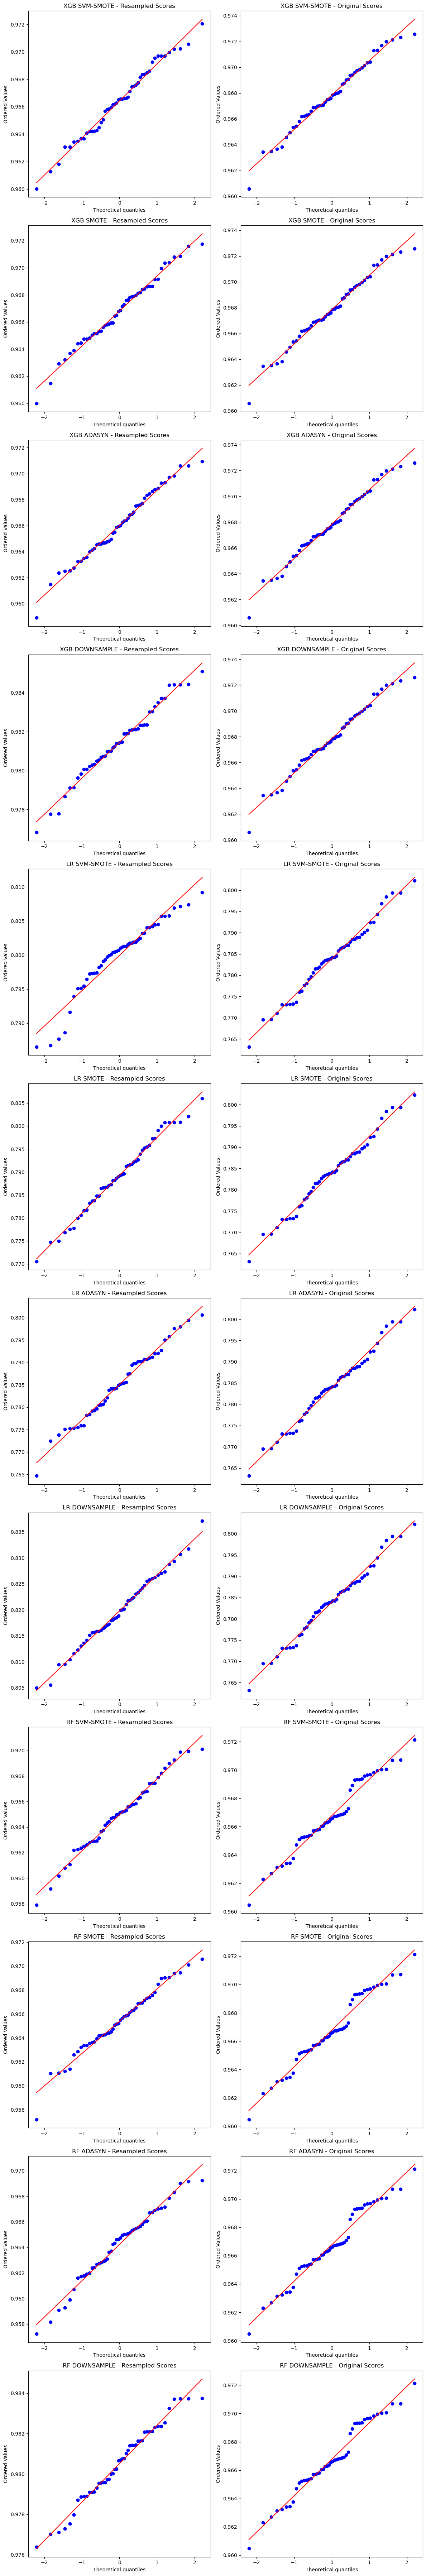

In [68]:
import matplotlib.pyplot as plt

n_rows = len(models)
n_cols = 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 6*n_rows))

for idx, (model, resampled_scores, original_scores) in enumerate(models):
    stats.probplot(resampled_scores['test_f1'], dist="norm", plot=axs[idx, 0])
    axs[idx, 0].set_title(f'{model} - Resampled Scores')
    
    stats.probplot(original_scores['test_f1'], dist="norm", plot=axs[idx, 1])
    axs[idx, 1].set_title(f'{model} - Original Scores')

plt.tight_layout()
plt.show()

In [69]:
def t_test_and_dataframe(score1, score2, model_name):
    t_stat, p_val = stats.ttest_ind(score1["test_f1"], score2["test_f1"])
    return pd.DataFrame({'Model': [model_name], 't-stat': [t_stat], 'p-value': [p_val]})

models = [('XGB SVM-SMOTE', scores_svmsmote_xgb, scores_xgb),
          ('XGB SMOTE', scores_smote_xgb, scores_xgb),
          ('XGB ADASYN', scores_adasyn_xgb, scores_xgb),
          ('XGB DOWNSAMPLE', scores_bal_xgb, scores_xgb),
          ('LR SVM-SMOTE', scores_svmsmote_lr, scores_lr),
          ('LR SMOTE', scores_smote_lr, scores_lr),
          ('LR ADASYN', scores_adasyn_lr, scores_lr),
          ('LR DOWNSAMPLE', scores_bal_lr, scores_lr),
          ('RF SVM-SMOTE', scores_svmsmote_rf, scores_rf),
          ('RF SMOTE', scores_smote_rf, scores_rf),
          ('RF ADASYN', scores_adasyn_rf, scores_rf),
          ('RF DOWNSAMPLE', scores_bal_rf, scores_rf)]

t_test_dfs = [t_test_and_dataframe(score1, score2, model_name) for model_name, score1, score2 in models]

t_test_results = pd.concat(t_test_dfs, ignore_index=True)
t_test_results['significant'] = t_test_results['p-value'].apply(lambda x: 'Yes' if x < 0.05 else 'No')
t_test_results['comparison_to_baseline'] = t_test_results.apply(lambda x: 'Better' if x['t-stat'] > 0 and x['p-value'] < 0.05 
                                                                else ('Worse' if x['t-stat'] < 0 and x['p-value'] < 0.05 else 'No Difference'), axis=1)

display(t_test_results)

,Model,t-stat,p-value,significant,comparison_to_baseline
0,XGB SVM-SMOTE,-2.722348,7.673276e-03,Yes,Worse
1,XGB SMOTE,-2.022473,4.585226e-02,Yes,Worse
2,XGB ADASYN,-3.472041,7.700717e-04,Yes,Worse
3,XGB DOWNSAMPLE,30.160274,2.162910e-51,Yes,Better
4,LR SVM-SMOTE,11.379610,1.266945e-19,Yes,Better
5,LR SMOTE,3.262844,1.518829e-03,Yes,Better
6,LR ADASYN,0.728417,4.680957e-01,No,No Difference
7,LR DOWNSAMPLE,23.332129,8.479708e-42,Yes,Better
8,RF SVM-SMOTE,-3.414277,9.315339e-04,Yes,Worse
9,RF SMOTE,-2.651893,9.336484e-03,Yes,Worse


Feature Selection

SFS Forward

In [32]:
sfs_results = pd.read_parquet('data/parquet_files/agg_featselect_results.parquet')
sfs_results_sorted = sfs_results.sort_values(by=['f1'], ascending=False).reset_index(drop=True)
display(sfs_results_sorted.head(20))
xgb_15_features = sfs_results_sorted.iloc[0]['selected_features']
print(xgb_15_features)
rf_15_features = sfs_results_sorted.iloc[4]['selected_features']
print(rf_15_features)
lr_15_features = sfs_results_sorted.iloc[12]['selected_features']
print(lr_15_features)

,model,num_features,selected_features,accuracy,precision,recall,f1
0,xgb_15,15,"[total_tx_with_contracts, total_incoming_eth, ...",0.977607,0.945359,0.989962,0.967139
1,xgb_14,14,"[total_tx_with_contracts, total_incoming_eth, ...",0.977558,0.945339,0.989831,0.967067
2,xgb_13,13,"[total_tx_with_contracts, total_incoming_eth, ...",0.977374,0.944723,0.989967,0.966809
3,xgb_12,12,"[total_tx_with_contracts, total_incoming_eth, ...",0.977213,0.943290,0.991146,0.966619
4,rf_15,15,"[total_tx_with_contracts, total_incoming_eth, ...",0.976961,0.946156,0.986970,0.966125
5,rf_14,14,"[total_tx_with_contracts, total_incoming_eth, ...",0.976733,0.945811,0.986646,0.965790
6,xgb_11,11,"[total_tx_with_contracts, total_incoming_eth, ...",0.976428,0.941848,0.990348,0.965482
7,rf_13,13,"[total_tx_with_contracts, total_incoming_eth, ...",0.976302,0.944449,0.986867,0.965185
8,rf_12,12,"[total_tx_with_contracts, total_incoming_eth, ...",0.975678,0.942281,0.987431,0.964321
9,rf_11,11,"[total_tx_with_contracts, total_incoming_eth, ...",0.974674,0.942677,0.983753,0.962769


['total_tx_with_contracts' 'total_incoming_eth' 'total_outgoing_eth'
 'avg_time_diff_out_minutes' 'total_incoming_erc20eth' 'min_erc20token_in'
 'max_erc20token_out' 'incoming_erc_1155_tnx' 'outgoing_erc_721_tnx'
 'total_erc_721_tnx' 'num_unique_erc721asset_out'
 'num_unique_erc721asset_in' 'median_recency_out' 'median_recency_in'
 'num_outliers_eth_in']
['total_tx_with_contracts' 'total_incoming_eth' 'total_outgoing_eth'
 'avg_time_diff_in_minutes' 'total_incoming_erc20eth' 'min_erc20token_in'
 'min_erc20token_out' 'incoming_erc_1155_tnx' 'outgoing_erc_721_tnx'
 'total_erc_721_tnx' 'num_unique_erc721asset_out'
 'num_unique_erc721asset_in' 'median_recency_out' 'median_recency_in'
 'num_outliers_eth_out']
['avg_time_diff_out_minutes' 'incoming_erc_20_tnx' 'total_erc_20_tnx'
 'total_incoming_erc20eth' 'min_erc20token_in' 'min_erc20token_out'
 'outgoing_erc_1155_tnx' 'incoming_erc_1155_tnx' 'outgoing_erc_721_tnx'
 'total_erc_721_tnx' 'num_unique_erc721asset_out'
 'num_unique_erc721asset_i

In [33]:
sfs_results_bal = pd.read_parquet('data/parquet_files/agg_featselect_results_balanced.parquet')
sfs_results_bal_sorted = sfs_results_bal.sort_values(by=['f1'], ascending=False).reset_index(drop=True)
display(sfs_results_bal_sorted.head(20))
xgb_bal_15_features = sfs_results_bal_sorted.iloc[0]['selected_features']
print(xgb_bal_15_features)
rf_bal_15_features = sfs_results_bal_sorted.iloc[4]['selected_features']
print(rf_bal_15_features)
lr_bal_15_features = sfs_results_bal_sorted.iloc[12]['selected_features']
print(lr_bal_15_features)

,model,num_features,selected_features,accuracy,precision,recall,f1
0,xgb_15,15,"[total_tx_with_contracts, total_incoming_eth, ...",0.981024,0.968879,0.993882,0.981218
1,xgb_14,14,"[total_tx_with_contracts, total_incoming_eth, ...",0.980630,0.968159,0.993854,0.980835
2,xgb_13,13,"[total_tx_with_contracts, total_incoming_eth, ...",0.980504,0.968129,0.993623,0.980708
3,xgb_12,12,"[total_tx_with_contracts, total_incoming_eth, ...",0.980236,0.967321,0.993957,0.980455
4,rf_15,15,"[total_tx_with_contracts, total_incoming_eth, ...",0.980138,0.968941,0.991977,0.980321
5,xgb_11,11,"[total_tx_with_contracts, total_incoming_eth, ...",0.979948,0.967046,0.993661,0.980170
6,rf_14,14,"[total_tx_with_contracts, total_incoming_eth, ...",0.979805,0.968452,0.991822,0.979994
7,rf_13,13,"[total_tx_with_contracts, total_incoming_eth, ...",0.979167,0.967044,0.992043,0.979380
8,rf_12,12,"[total_tx_with_contracts, total_incoming_eth, ...",0.979172,0.968451,0.990510,0.979353
9,rf_11,11,"[total_tx_with_contracts, total_incoming_eth, ...",0.978911,0.968303,0.990134,0.979092


['total_tx_with_contracts' 'total_incoming_eth' 'total_outgoing_eth'
 'avg_time_diff_out_minutes' 'total_erc_20_tnx' 'total_incoming_erc20eth'
 'num_unique_erc20tokens_in' 'incoming_erc_1155_tnx'
 'outgoing_erc_721_tnx' 'total_erc_721_tnx' 'num_unique_erc721asset_out'
 'num_unique_erc721asset_in' 'daily_total_gini_index' 'median_recency_in'
 'num_outliers_eth_out']
['total_tx_with_contracts' 'total_incoming_eth' 'total_outgoing_eth'
 'total_avg_time_diff_minutes' 'total_erc_20_tnx'
 'total_incoming_erc20eth' 'num_unique_erc20tokens_in'
 'incoming_erc_1155_tnx' 'outgoing_erc_721_tnx' 'total_erc_721_tnx'
 'num_unique_erc721asset_out' 'num_unique_erc721asset_in'
 'median_recency_out' 'median_recency_in' 'num_outliers_eth_in']
['total_tx_with_contracts' 'total_incoming_eth'
 'avg_time_diff_out_minutes' 'avg_time_diff_in_minutes'
 'incoming_erc_20_tnx' 'total_erc_20_tnx' 'total_incoming_erc20eth'
 'min_erc20token_in' 'min_erc20token_out' 'incoming_erc_1155_tnx'
 'outgoing_erc_721_tnx' 'tota

In [8]:
sfs_results_tex = sfs_results_sorted[['model', 'num_features', 'accuracy', 'precision', 'recall', 'f1']]
sfs_results_bal_tex = sfs_results_bal_sorted[['model', 'num_features', 'accuracy', 'precision', 'recall', 'f1']]

sfs_results_tex.to_latex('sfs_results.tex', index=False)
sfs_results_bal_tex.to_latex('sfs_results_bal.tex', index=False)

/var/folders/xs/x2x4yg29089c8t_v4z9nymz40000gn/T/ipykernel_79352/3405963588.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  sfs_results_tex.to_latex('sfs_results.tex', index=False)
/var/folders/xs/x2x4yg29089c8t_v4z9nymz40000gn/T/ipykernel_79352/3405963588.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  sfs_results_bal_tex.to_latex('sfs_results_bal.tex', index=False)


Adding RFM and Gini Features to XGB

In [76]:
features_to_test = ['weekly_total_gini_index', 'daily_total_gini_index', 'num_outliers_eth_out']

selected_feat_xgb = X_train[xgb_15_features]

import itertools

results = []

rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)

for r in range(1, len(features_to_test) + 1):
    combinations = list(itertools.combinations(features_to_test, r))

    for combo in combinations:
        new_features = list(selected_feat_xgb) + list(combo)
        xgb = XGBClassifier(n_jobs=-1)
        scores = cross_val_score(xgb, X_train[new_features], y_train, cv=rskf, scoring='f1')
        mean_f1 = scores.mean()

        results.append({
            "mean_f1_score": mean_f1,
            "added_features": combo,
            "features": new_features
        })

results_df = pd.DataFrame(results)
results_df.to_parquet('models/results_df_xgb.parquet')

In [77]:
results_df = pd.read_parquet('models/results_df_xgb.parquet')
filtered_result_df = results_df[results_df['features'].map(len) <= 18]
filtered_result_df['num_features'] = filtered_result_df['features'].map(len)
filtered_result_df.sort_values(by='mean_f1_score', ascending=False, inplace=True)
display(filtered_result_df)
latex_table1 = filtered_result_df[['mean_f1_score', 'added_features', 'num_features']]
latex_table1['Model'] = 'XGB 15'

,mean_f1_score,added_features,features,num_features
5,0.968034,"[daily_total_gini_index, num_outliers_eth_out]","[total_tx_with_contracts, total_incoming_eth, ...",17
6,0.967847,"[weekly_total_gini_index, daily_total_gini_ind...","[total_tx_with_contracts, total_incoming_eth, ...",18
4,0.967793,"[weekly_total_gini_index, num_outliers_eth_out]","[total_tx_with_contracts, total_incoming_eth, ...",17
3,0.967751,"[weekly_total_gini_index, daily_total_gini_index]","[total_tx_with_contracts, total_incoming_eth, ...",17
1,0.967717,[daily_total_gini_index],"[total_tx_with_contracts, total_incoming_eth, ...",16
0,0.967619,[weekly_total_gini_index],"[total_tx_with_contracts, total_incoming_eth, ...",16
2,0.967484,[num_outliers_eth_out],"[total_tx_with_contracts, total_incoming_eth, ...",16


In [78]:
best_added_xgb_features = filtered_result_df.iloc[0]['added_features']
best_added_xgb_features

array(['daily_total_gini_index', 'num_outliers_eth_out'], dtype=object)

Adding RFM and Gini Features to XGB Balanced

In [79]:
features_to_test = ['weekly_total_gini_index', 'median_recency_out', 'num_outliers_eth_in']

selected_feat_xgb_bal = X_train_bal[xgb_bal_15_features]

import itertools

results = []

rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)

for r in range(1, len(features_to_test) + 1):
    combinations = list(itertools.combinations(features_to_test, r))
    for combo in combinations:
        new_features = list(selected_feat_xgb_bal) + list(combo)

        xgb = XGBClassifier(n_jobs=-1)
        scores = cross_val_score(xgb, X_train_bal[new_features], y_train_bal, cv=rskf, scoring='f1')
        mean_f1 = scores.mean()

        results.append({
            "mean_f1_score": mean_f1,
            "added_features": combo,
            "features": new_features
        })

results_df = pd.DataFrame(results)
results_df.to_parquet('models/results_df_xgb_bal.parquet')

In [80]:
results_df = pd.read_parquet('models/results_df_xgb_bal.parquet')
filtered_result_df = results_df[results_df['features'].map(len) <= 18]
filtered_result_df['num_features'] = filtered_result_df['features'].map(len)
filtered_result_df.sort_values(by='mean_f1_score', ascending=False, inplace=True)
display(filtered_result_df)
latex_table4 = filtered_result_df[['mean_f1_score', 'added_features', 'num_features']]
latex_table4['Model'] = 'XGB BAL 15'

,mean_f1_score,added_features,features,num_features
5,0.981595,"[median_recency_out, num_outliers_eth_in]","[total_tx_with_contracts, total_incoming_eth, ...",17
1,0.981547,[median_recency_out],"[total_tx_with_contracts, total_incoming_eth, ...",16
6,0.981513,"[weekly_total_gini_index, median_recency_out, ...","[total_tx_with_contracts, total_incoming_eth, ...",18
3,0.981476,"[weekly_total_gini_index, median_recency_out]","[total_tx_with_contracts, total_incoming_eth, ...",17
2,0.981439,[num_outliers_eth_in],"[total_tx_with_contracts, total_incoming_eth, ...",16
4,0.981415,"[weekly_total_gini_index, num_outliers_eth_in]","[total_tx_with_contracts, total_incoming_eth, ...",17
0,0.981306,[weekly_total_gini_index],"[total_tx_with_contracts, total_incoming_eth, ...",16


In [81]:
best_added_xgb_features_bal = filtered_result_df.iloc[0]['added_features']
best_added_xgb_features_bal

array(['median_recency_out', 'num_outliers_eth_in'], dtype=object)

Adding RFM and Gini Features to RF

In [82]:
features_to_test = ['weekly_total_gini_index', 'daily_total_gini_index', 'num_outliers_eth_in']

selected_feat_rf = X_train[rf_15_features]

import itertools

results = []

for r in range(1, len(features_to_test) + 1):
    combinations = list(itertools.combinations(features_to_test, r))

    for combo in combinations:
        new_features = list(selected_feat_rf) + list(combo)

        rf = RandomForestClassifier(n_jobs=-1)
        scores = cross_val_score(rf, X_train[new_features], y_train, cv=rskf, scoring='f1')
        mean_f1 = scores.mean()

        results.append({
            "mean_f1_score": mean_f1,
            "added_features": combo,
            "features": new_features
        })

results_df = pd.DataFrame(results)
results_df.to_parquet('models/results_df_rf.parquet')

In [83]:
results_df = pd.read_parquet('models/results_df_rf.parquet')
filtered_result_df = results_df[results_df['features'].map(len) <= 18]
filtered_result_df['num_features'] = filtered_result_df['features'].map(len)
filtered_result_df.sort_values(by='mean_f1_score', ascending=False, inplace=True)
display(filtered_result_df)
latex_table2 = filtered_result_df[['mean_f1_score', 'added_features', 'num_features']]
latex_table2['Model'] = 'RF 15'

,mean_f1_score,added_features,features,num_features
4,0.966454,"[weekly_total_gini_index, num_outliers_eth_in]","[total_tx_with_contracts, total_incoming_eth, ...",17
6,0.966351,"[weekly_total_gini_index, daily_total_gini_ind...","[total_tx_with_contracts, total_incoming_eth, ...",18
5,0.966331,"[daily_total_gini_index, num_outliers_eth_in]","[total_tx_with_contracts, total_incoming_eth, ...",17
2,0.966218,[num_outliers_eth_in],"[total_tx_with_contracts, total_incoming_eth, ...",16
1,0.966191,[daily_total_gini_index],"[total_tx_with_contracts, total_incoming_eth, ...",16
0,0.966135,[weekly_total_gini_index],"[total_tx_with_contracts, total_incoming_eth, ...",16
3,0.965975,"[weekly_total_gini_index, daily_total_gini_index]","[total_tx_with_contracts, total_incoming_eth, ...",17


In [84]:
best_added_rf_features = filtered_result_df.iloc[0]['added_features']
best_added_rf_features

array(['weekly_total_gini_index', 'num_outliers_eth_in'], dtype=object)

Adding RFM and Gini Features to RF Balanced

In [85]:
features_to_test = ['weekly_total_gini_index', 'daily_total_gini_index', 'num_outliers_eth_out']

selected_feat_rf_bal = X_train_bal[rf_bal_15_features]

import itertools

results = []

for r in range(1, len(features_to_test) + 1):
    combinations = list(itertools.combinations(features_to_test, r))

    for combo in combinations:
        new_features = list(selected_feat_rf_bal) + list(combo)

        rf = RandomForestClassifier(n_jobs=-1)
        scores = cross_val_score(rf, X_train_bal[new_features], y_train_bal, cv=rskf, scoring='f1')
        mean_f1 = scores.mean()

        results.append({
            "mean_f1_score": mean_f1,
            "added_features": combo,
            "features": new_features
        })

results_df = pd.DataFrame(results)
results_df.to_parquet('models/results_df_rf_bal.parquet')

In [86]:
results_df = pd.read_parquet('models/results_df_rf_bal.parquet')
filtered_result_df = results_df[results_df['features'].map(len) <= 18]
filtered_result_df['num_features'] = filtered_result_df['features'].map(len)
filtered_result_df.sort_values(by='mean_f1_score', ascending=False, inplace=True)
display(filtered_result_df)
latex_table3 = filtered_result_df[['mean_f1_score', 'added_features', 'num_features']]
latex_table3['Model'] = 'RF BAL 15'

,mean_f1_score,added_features,features,num_features
2,0.980617,[num_outliers_eth_out],"[total_tx_with_contracts, total_incoming_eth, ...",16
4,0.980483,"[weekly_total_gini_index, num_outliers_eth_out]","[total_tx_with_contracts, total_incoming_eth, ...",17
5,0.980460,"[daily_total_gini_index, num_outliers_eth_out]","[total_tx_with_contracts, total_incoming_eth, ...",17
3,0.980316,"[weekly_total_gini_index, daily_total_gini_index]","[total_tx_with_contracts, total_incoming_eth, ...",17
6,0.980304,"[weekly_total_gini_index, daily_total_gini_ind...","[total_tx_with_contracts, total_incoming_eth, ...",18
1,0.980304,[daily_total_gini_index],"[total_tx_with_contracts, total_incoming_eth, ...",16
0,0.980228,[weekly_total_gini_index],"[total_tx_with_contracts, total_incoming_eth, ...",16


In [87]:
best_added_rf_features_bal = filtered_result_df.iloc[1]['added_features']
best_added_rf_features_bal

array(['weekly_total_gini_index', 'num_outliers_eth_out'], dtype=object)

In [88]:
latex_table_add_rfm = pd.concat([latex_table1, latex_table4, latex_table2, latex_table3], axis=0)
latex_table_add_rfm = latex_table_add_rfm[['Model', 'mean_f1_score', 'added_features', 'num_features']]
latex_table_add_rfm.to_latex('latex_table_add_rfm.tex', index=False)

/var/folders/xs/x2x4yg29089c8t_v4z9nymz40000gn/T/ipykernel_79352/239657974.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table_add_rfm.to_latex('latex_table_add_rfm.tex', index=False)


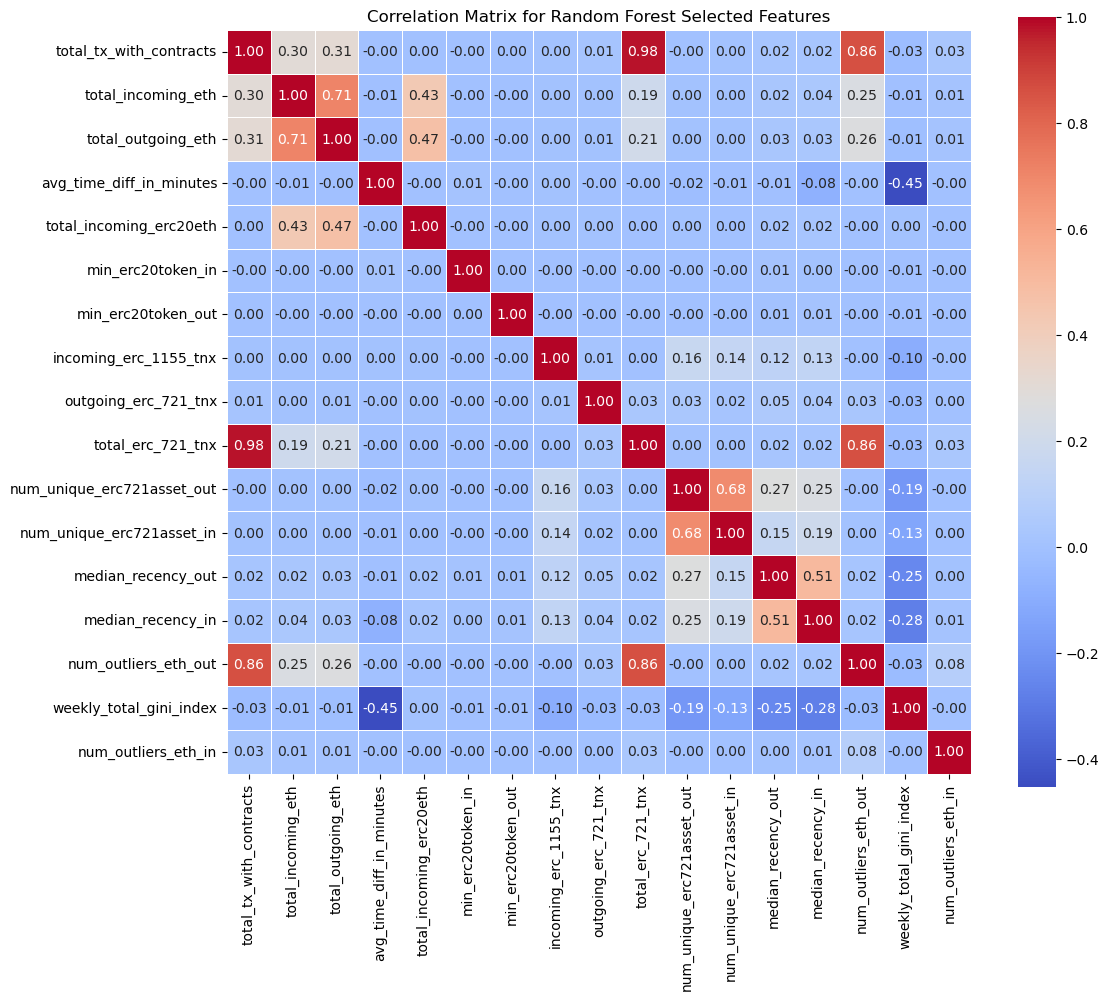

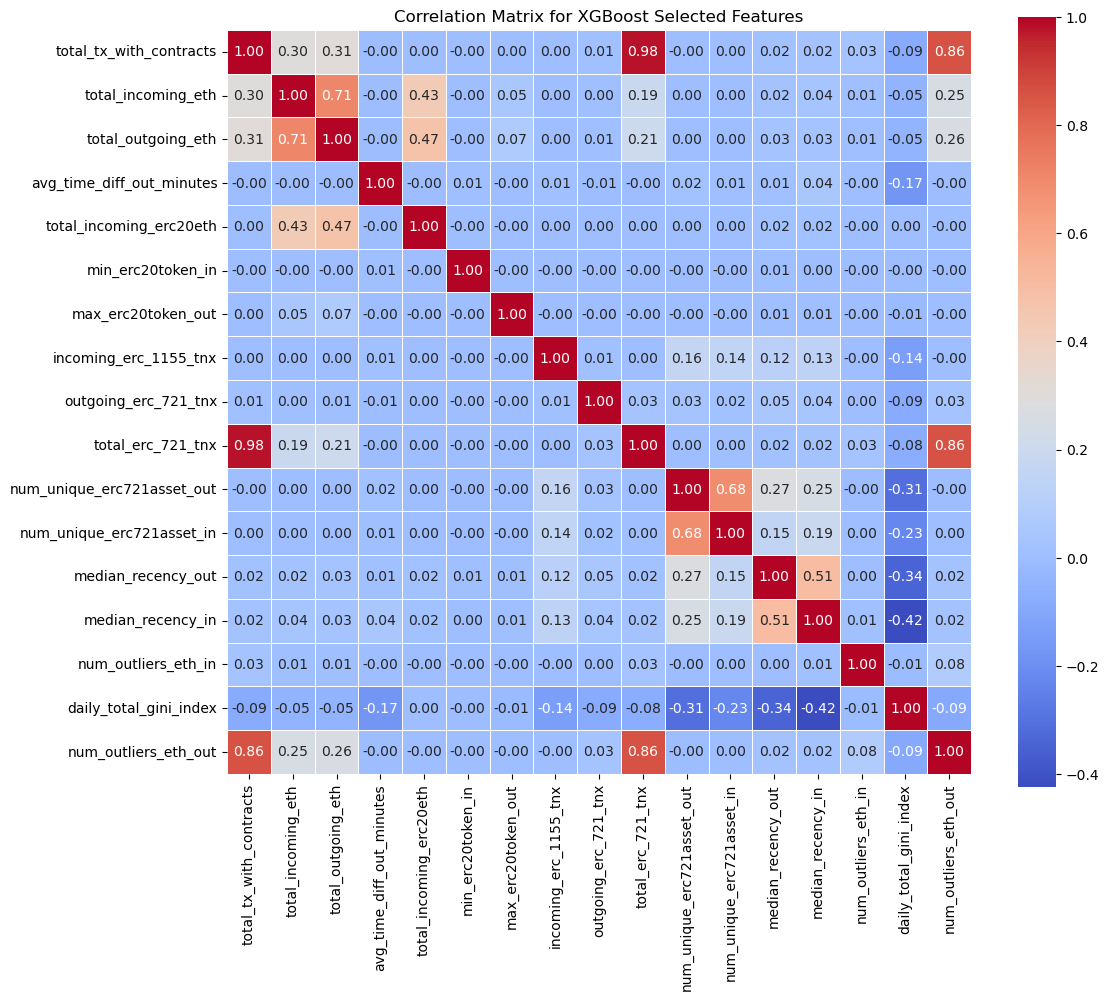

In [89]:
sfs_rf = pd.read_pickle('models/sfs_rf_15.pkl')
sfs_feat_rf = list(X_train.columns[(sfs_rf.get_support())])
sfs_feat_rf += list(best_added_rf_features)

sfs_xgb = pd.read_pickle('models/sfs_xgb_15.pkl')
sfs_feat_xgb = list(X_train.columns[(sfs_xgb.get_support())])
sfs_feat_xgb += list(best_added_xgb_features)

corr_rf = training_data_rfm[sfs_feat_rf].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_rf, annot=True, fmt=".2f", cmap='coolwarm', 
            cbar=True, square=True, linewidths=.5,
            annot_kws={'size': 10})

plt.title("Correlation Matrix for Random Forest Selected Features")
plt.show()

corr_xgb = training_data_rfm[sfs_feat_xgb].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_xgb, annot=True, fmt=".2f", cmap='coolwarm', 
            cbar=True, square=True, linewidths=.5,
            annot_kws={'size': 10})

plt.title("Correlation Matrix for XGBoost Selected Features")
plt.show()

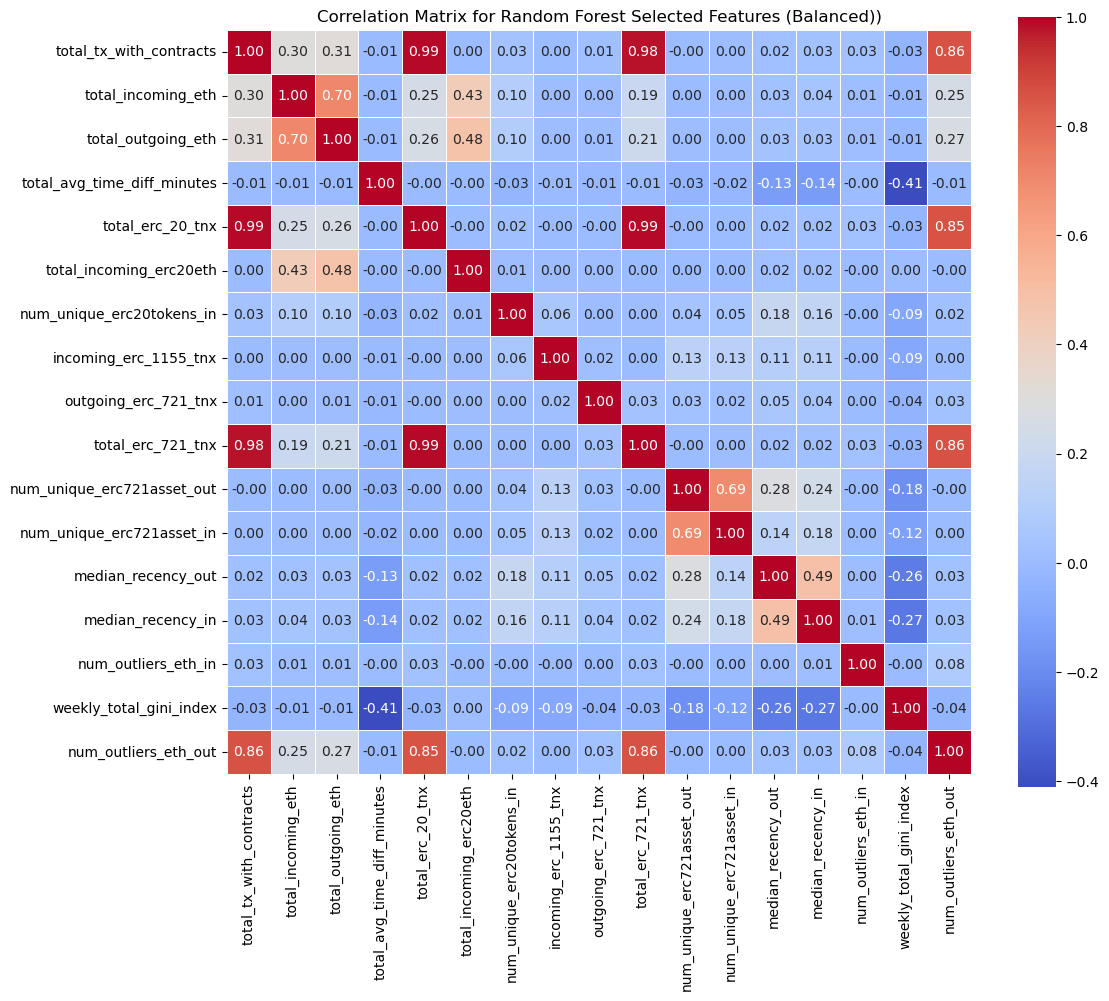

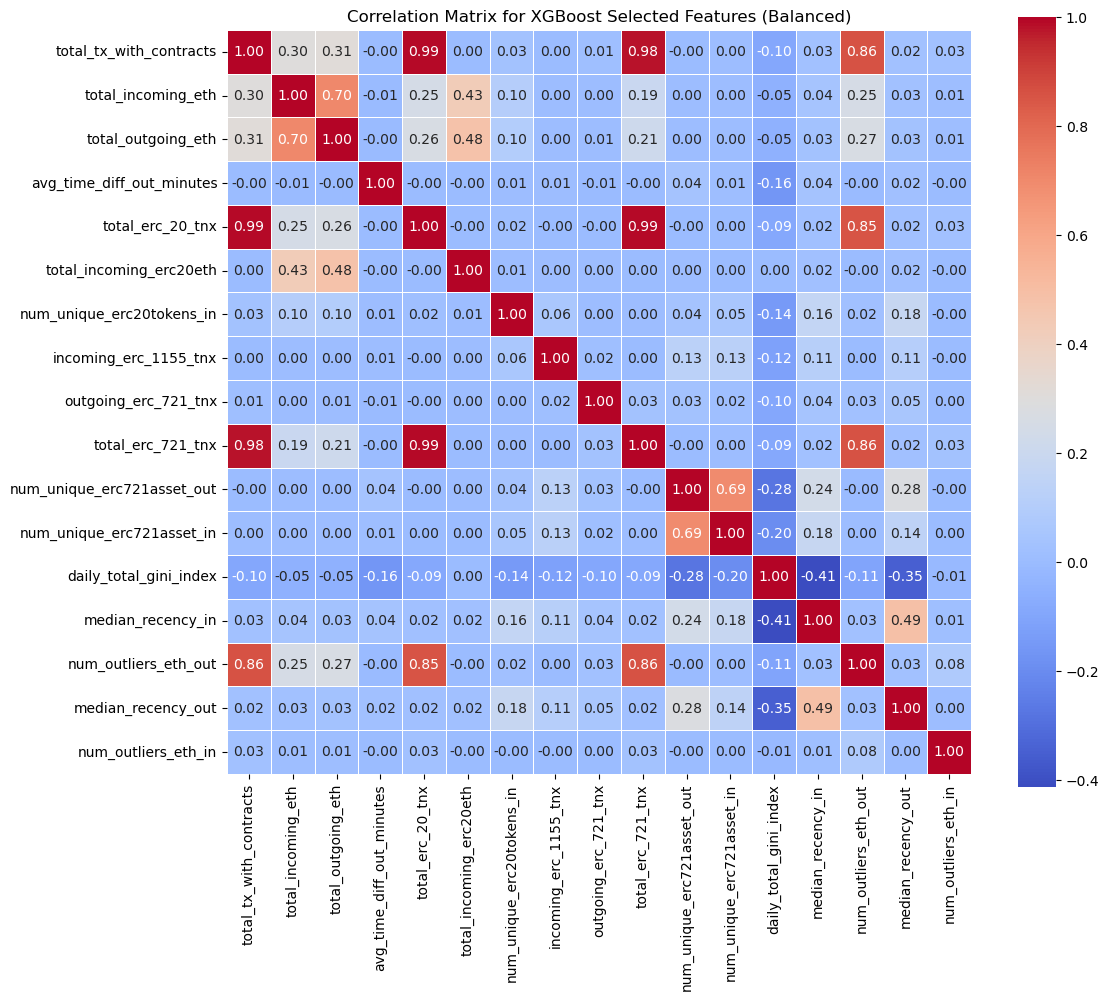

In [90]:
sfs_rf_bal = pd.read_pickle('models/sfs_rf_15_balanced.pkl')
sfs_feat_rf_bal = list(X_train_bal.columns[(sfs_rf_bal.get_support())])
sfs_feat_rf_bal += list(best_added_rf_features_bal)

sfs_xgb_bal = pd.read_pickle('models/sfs_xgb_15_balanced.pkl')
sfs_feat_xgb_bal = list(X_train_bal.columns[(sfs_xgb_bal.get_support())])
sfs_feat_xgb_bal += list(best_added_xgb_features_bal)

corr_rf = training_data_rfm_balanced[sfs_feat_rf_bal].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_rf, annot=True, fmt=".2f", cmap='coolwarm', 
            cbar=True, square=True, linewidths=.5,
            annot_kws={'size': 10})

plt.title("Correlation Matrix for Random Forest Selected Features (Balanced))")
plt.show()

corr_xgb = training_data_rfm_balanced[sfs_feat_xgb_bal].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_xgb, annot=True, fmt=".2f", cmap='coolwarm', 
            cbar=True, square=True, linewidths=.5,
            annot_kws={'size': 10})

plt.title("Correlation Matrix for XGBoost Selected Features (Balanced)")
plt.show()

ROC AUC Score

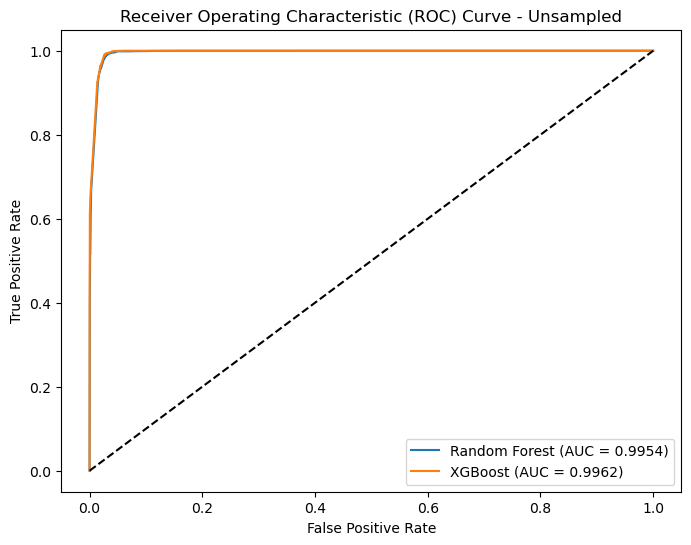

Random Forest AUC: 0.9954
XGBoost AUC: 0.9962
0.965883106192262
0.9689781021897811


In [124]:
sfs_rf = pd.read_pickle('models/sfs_rf_15.pkl')
sfs_feat_rf = list(X_train.columns[(sfs_rf.get_support())])
sfs_feat_rf += list(best_added_rf_features)

sfs_xgb = pd.read_pickle('models/sfs_xgb_15.pkl')
sfs_feat_xgb = list(X_train.columns[(sfs_xgb.get_support())])
sfs_feat_xgb += list(best_added_xgb_features)

X_train_sfs_rf = X_train[sfs_feat_rf].drop(columns=['num_outliers_eth_out', 'total_erc_721_tnx'])
X_test_sfs_rf = X_test[sfs_feat_rf].drop(columns=['num_outliers_eth_out', 'total_erc_721_tnx'])

X_train_sfs_xgb = X_train[sfs_feat_xgb].drop(columns=['num_outliers_eth_out', 'total_erc_721_tnx'])
X_test_sfs_xgb = X_test[sfs_feat_xgb].drop(columns=['num_outliers_eth_out', 'total_erc_721_tnx'])

rf = RandomForestClassifier(n_jobs=-1)
xgb = XGBClassifier(n_jobs=-1)

rf.fit(X_train_sfs_rf, y_train)
xgb.fit(X_train_sfs_xgb, y_train)

rf_probs = rf.predict_proba(X_test_sfs_rf)[:, 1]
xgb_probs = xgb.predict_proba(X_test_sfs_xgb)[:, 1]

true_labels = y_test

plt.figure(figsize=(8, 6))

# Random Forest ROC curve
rf_fpr, rf_tpr, _ = roc_curve(true_labels, rf_probs)
rf_auc = roc_auc_score(true_labels, rf_probs)
plt.plot(rf_fpr, rf_tpr, label='Random Forest (AUC = {:.4f})'.format(rf_auc))

# XGBoost ROC curve
xgb_fpr, xgb_tpr, _ = roc_curve(true_labels, xgb_probs)
xgb_auc = roc_auc_score(true_labels, xgb_probs)
plt.plot(xgb_fpr, xgb_tpr, label='XGBoost (AUC = {:.4f})'.format(xgb_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Unsampled')
plt.legend(loc='lower right')
plt.show()

print('Random Forest AUC: {:.4f}'.format(rf_auc))
print('XGBoost AUC: {:.4f}'.format(xgb_auc))

print(f1_score(y_test, rf.predict(X_test_sfs_rf)))
print(f1_score(y_test, xgb.predict(X_test_sfs_xgb)))

Precision-Recall Curve

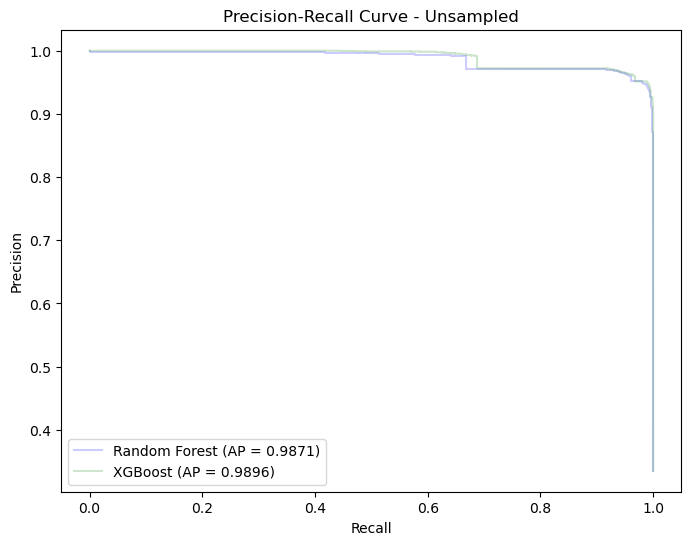

In [125]:
# Random Forest precision-recall
rf_precision, rf_recall, _ = precision_recall_curve(true_labels, rf_probs)
rf_average_precision = average_precision_score(true_labels, rf_probs)

# XGBoost precision-recall
xgb_precision, xgb_recall, _ = precision_recall_curve(true_labels, xgb_probs)
xgb_average_precision = average_precision_score(true_labels, xgb_probs)

plt.figure(figsize=(8, 6))

# Random Forest Precision-Recall curve
plt.step(rf_recall, rf_precision, color='b', alpha=0.2, where='post',
         label='Random Forest (AP = {:.4f})'.format(rf_average_precision))

# XGBoost Precision-Recall curve
plt.step(xgb_recall, xgb_precision, color='g', alpha=0.2, where='post',
         label='XGBoost (AP = {:.4f})'.format(xgb_average_precision))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Unsampled')
plt.legend(loc='lower left')
plt.show()

In [115]:
with open('models/X_train_sfs_xgb.pkl', 'wb') as f:
    pickle.dump(X_train_sfs_xgb, f)

with open('models/X_test_sfs_xgb.pkl', 'wb') as f:
    pickle.dump(X_test_sfs_xgb, f)

In [94]:
X_train_check = pd.read_pickle('models/X_train_sfs_xgb.pkl')
X_test_check = pd.read_pickle('models/X_test_sfs_xgb.pkl')

xgb_test = XGBClassifier(n_jobs=-1, random_state=42)
xgb_test.fit(X_train_check, y_train)
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
scores = cross_val_score(xgb_test, X_train_check, y_train, scoring='f1', cv=rskf, n_jobs=-1)
print('Mean F1 score: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
y_pred_test = xgb_test.predict(X_test_check)
print('Test F1 score: ', f1_score(y_test, y_pred_test))

Mean F1 score: 0.967 (0.002)
Test F1 score:  0.9689781021897811


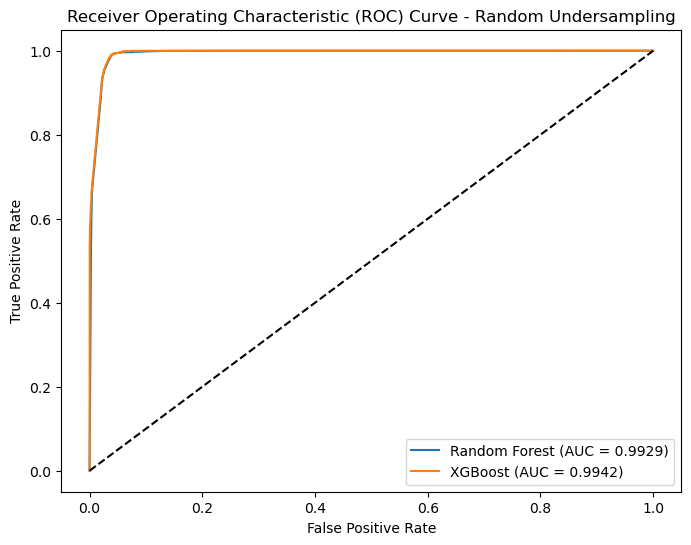

Random Forest AUC: 0.9929
XGBoost AUC: 0.9942


In [126]:
sfs_rf_bal = pd.read_pickle('models/sfs_rf_15_balanced.pkl')
sfs_feat_rf_bal = list(X_train_bal.columns[(sfs_rf_bal.get_support())])
sfs_feat_rf_bal += list(best_added_rf_features_bal)

sfs_xgb_bal = pd.read_pickle('models/sfs_xgb_15_balanced.pkl')
sfs_feat_xgb_bal = list(X_train_bal.columns[(sfs_xgb_bal.get_support())])
sfs_feat_xgb_bal += list(best_added_xgb_features_bal)

X_train_sfs_rf_bal = X_train_bal[sfs_feat_rf_bal].drop(columns=['num_outliers_eth_out', 'total_erc_721_tnx', 'total_erc_20_tnx'])
X_test_sfs_rf_bal = X_test_bal[sfs_feat_rf_bal].drop(columns=['num_outliers_eth_out', 'total_erc_721_tnx', 'total_erc_20_tnx'])

X_train_sfs_xgb_bal = X_train_bal[sfs_feat_xgb_bal].drop(columns=['num_outliers_eth_out', 'total_erc_721_tnx', 'total_erc_20_tnx'])
X_test_sfs_xgb_bal = X_test_bal[sfs_feat_xgb_bal].drop(columns=['num_outliers_eth_out', 'total_erc_721_tnx', 'total_erc_20_tnx'])

rf = RandomForestClassifier(n_jobs=-1)
xgb = XGBClassifier(n_jobs=-1)

rf.fit(X_train_sfs_rf_bal, y_train_bal)
xgb.fit(X_train_sfs_xgb_bal, y_train_bal)

rf_probs_bal = rf.predict_proba(X_test_sfs_rf_bal)[:, 1]
xgb_probs_bal = xgb.predict_proba(X_test_sfs_xgb_bal)[:, 1]

true_labels = y_test_bal

plt.figure(figsize=(8, 6))

# Random Forest ROC curve
rf_fpr, rf_tpr, _ = roc_curve(true_labels, rf_probs_bal)
rf_auc = roc_auc_score(true_labels, rf_probs_bal)
plt.plot(rf_fpr, rf_tpr, label='Random Forest (AUC = {:.4f})'.format(rf_auc))

# XGBoost ROC curve
xgb_fpr, xgb_tpr, _ = roc_curve(true_labels, xgb_probs_bal)
xgb_auc = roc_auc_score(true_labels, xgb_probs_bal)
plt.plot(xgb_fpr, xgb_tpr, label='XGBoost (AUC = {:.4f})'.format(xgb_auc))

plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Undersampling')
plt.legend(loc='lower right')
plt.show()

print('Random Forest AUC: {:.4f}'.format(rf_auc))
print('XGBoost AUC: {:.4f}'.format(xgb_auc))

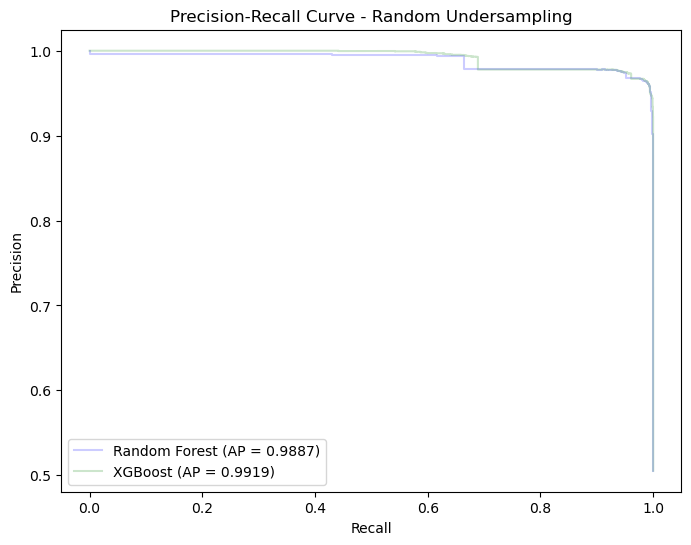

In [127]:
# Random Forest precision-recall
rf_precision, rf_recall, _ = precision_recall_curve(true_labels, rf_probs_bal)
rf_average_precision = average_precision_score(true_labels, rf_probs_bal)

# XGBoost precision-recall
xgb_precision, xgb_recall, _ = precision_recall_curve(true_labels, xgb_probs_bal)
xgb_average_precision = average_precision_score(true_labels, xgb_probs_bal)

plt.figure(figsize=(8, 6))

# Random Forest Precision-Recall curve
plt.step(rf_recall, rf_precision, color='b', alpha=0.2, where='post',
         label='Random Forest (AP = {:.4f})'.format(rf_average_precision))

# XGBoost Precision-Recall curve
plt.step(xgb_recall, xgb_precision, color='g', alpha=0.2, where='post',
         label='XGBoost (AP = {:.4f})'.format(xgb_average_precision))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Undersampling')
plt.legend(loc='lower left')
plt.show()

In [98]:
with open('models/X_train_sfs_xgb_balanced.pkl', 'wb') as f:
    pickle.dump(X_train_sfs_xgb_bal, f)

with open('models/X_test_sfs_xgb_balanced.pkl', 'wb') as f:
    pickle.dump(X_test_sfs_xgb_bal, f)

In [99]:
X_train_check_bal = pd.read_pickle('models/X_train_sfs_xgb_balanced.pkl')
X_test_check_bal = pd.read_pickle('models/X_test_sfs_xgb_balanced.pkl')

xgb_test = XGBClassifier(n_jobs=-1, random_state=42)
xgb_test.fit(X_train_check_bal, y_train_bal)
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
scores = cross_val_score(xgb_test, X_train_check_bal, y_train_bal, scoring='f1', cv=rskf, n_jobs=-1)
print('Mean F1 score: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
y_pred_test_bal = xgb_test.predict(X_test_check_bal)
print('Test F1 score: ', f1_score(y_test_bal, y_pred_test_bal))

Mean F1 score: 0.976 (0.002)
Test F1 score:  0.9760643157317742


In [102]:
best_trial = pd.read_pickle('models/bohb_xgb.pkl')
bohb_best_params = best_trial['best_params']
print(bohb_best_params)
best_loss = best_trial['best_loss']
bohb_train_f1_score = 1 - best_loss
xgb_bohb_best = XGBClassifier(**bohb_best_params, n_jobs=-1, random_state=42)

X_train_sfs_xgb = pd.read_pickle('models/X_train_sfs_xgb.pkl')
X_test_sfs_xgb = pd.read_pickle('models/X_test_sfs_xgb.pkl')

xgb_bohb_best.fit(X_train_sfs_xgb, y_train)
y_pred_xgb_bohb_best = xgb_bohb_best.predict(X_test_sfs_xgb)
bohb_test_f1_score = f1_score(y_test, y_pred_xgb_bohb_best)

print('Score on validate: {}, score on test: {}'.format(bohb_train_f1_score, bohb_test_f1_score))

{'eta': 0.10576687471707759, 'max_depth': 13, 'min_child_weight': 3, 'gamma': 0.710379652917677, 'lambda': 1.1001565634461392, 'alpha': 0.7416710203657426, 'scale_pos_weight': 1.2568657799754468, 'subsample': 0.7242198434888607, 'colsample_bytree': 0.6640203632044244, 'n_estimators': 366}
Score on validate: 0.9677787374563984, score on test: 0.9697854860794158


In [100]:
best_trial_bal = pd.read_pickle('models/bohb_xgb_balanced.pkl')
bohb_best_params_bal = best_trial_bal['best_params']
print(bohb_best_params_bal)
best_loss_bal = best_trial_bal['best_loss']
bohb_train_f1_score_bal = 1 - best_loss_bal
xgb_bohb_best_bal = XGBClassifier(**bohb_best_params_bal, n_jobs=-1, random_state=42)

X_train_sfs_xgb_bal = pd.read_pickle('models/X_train_sfs_xgb_balanced.pkl')
X_test_sfs_xgb_bal = pd.read_pickle('models/X_test_sfs_xgb_balanced.pkl')

xgb_bohb_best_bal.fit(X_train_sfs_xgb_bal, y_train_bal)
y_pred_xgb_bohb_best_bal = xgb_bohb_best_bal.predict(X_test_sfs_xgb_bal)
bohb_test_f1_score_bal = f1_score(y_test_bal, y_pred_xgb_bohb_best_bal)

print('Score on validate: {}, score on test: {}'.format(bohb_train_f1_score_bal, bohb_test_f1_score_bal))

{'eta': 0.049200141401370474, 'max_depth': 8, 'min_child_weight': 3, 'gamma': 0.6585636262934619, 'lambda': 0.044082573687641124, 'alpha': 0.5719565799420181, 'scale_pos_weight': 1.733405874969467, 'subsample': 0.8477302496874599, 'colsample_bytree': 0.5941578687923456, 'n_estimators': 276}
Score on validate: 0.9761869919322596, score on test: 0.9766423357664233


In [128]:
with open('models/xgb_bohb_best.pkl', 'wb') as f:
    pickle.dump(xgb_bohb_best, f)

xgb_bohb_best.save_model('models/xgb_bohb_best.json')

with open('models/xgb_bohb_best_bal.pkl', 'wb') as f:
    pickle.dump(xgb_bohb_best_bal, f)

xgb_bohb_best_bal.save_model('models/xgb_bohb_best_bal.json')

: 

XGBoost BOHB AUC: 0.9966
XGBoost BOHB Balanced AUC: 0.9943


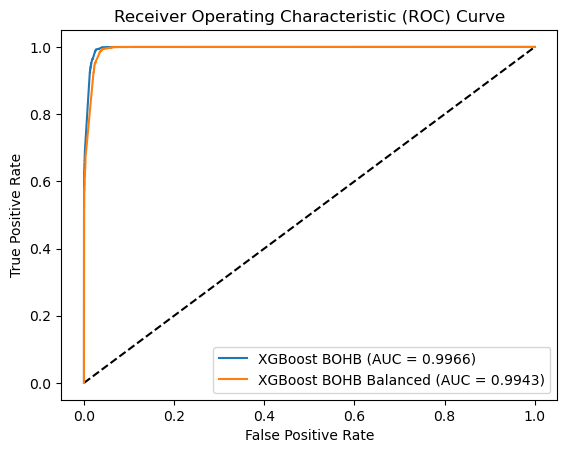

In [122]:
def plot_roc_curve(model_path, x_pred, y_target, label):
    model = pd.read_pickle(model_path)
    probs = model.predict_proba(x_pred)[:, 1]
    fpr, tpr, _ = roc_curve(y_target, probs)
    auc_score = roc_auc_score(y_target, probs)
    plt.plot(fpr, tpr, label='{} (AUC = {:.4f})'.format(label, auc_score))
    return auc_score

models = [
    ('models/xgb_bohb_best.pkl', X_test_sfs_xgb, y_test, 'XGBoost BOHB'),
    ('models/xgb_bohb_best_bal.pkl', X_test_sfs_xgb_bal, y_test_bal, 'XGBoost BOHB Balanced')
]

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

for model_path, x_pred, y_target, label in models:
    auc_curve = plot_roc_curve(model_path, x_pred, y_target, label)
    print('{} AUC: {:.4f}'.format(label, auc_curve))

plt.legend(loc='lower right')
plt.show()


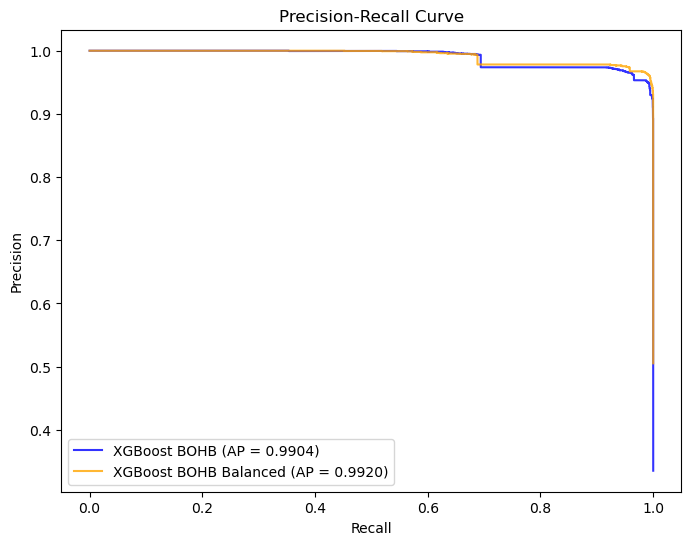

In [123]:
plt.figure(figsize=(8, 6))

colors = ['b', 'orange', 'g', 'r']

for idx, (model_path, x_pred, y_target, label) in enumerate(models):
    model = pd.read_pickle(model_path)
    probs = model.predict_proba(x_pred)[:, 1]
    precision, recall, _ = precision_recall_curve(y_target, probs)
    average_precision = average_precision_score(y_target, probs)
    plt.step(recall, precision, color=colors[idx], alpha=0.8, where='post',
             label='{} (AP = {:.4f})'.format(label, average_precision))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

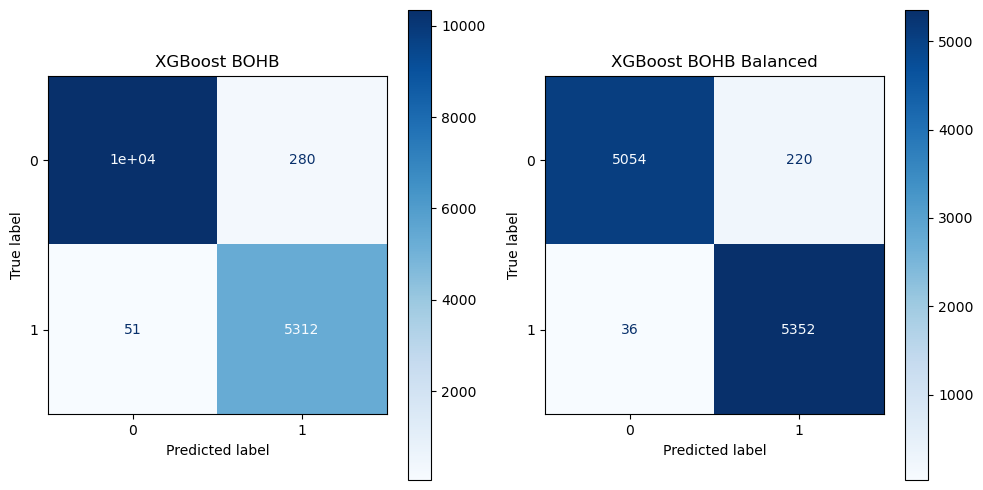

In [106]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()

for idx, (model_path, X_test, y_test, label) in enumerate(models):
    model = pd.read_pickle(model_path)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[idx], cmap=plt.cm.Blues)
    axes[idx].set_title(label)

plt.tight_layout()
plt.show()

In [9]:
all_june_accounts_df = pd.read_parquet('data/parquet_files/all_june_accounts_df.parquet')

,address,address_id,year_month,outgoing_tx_count,incoming_tx_count,unique_received_transactions,unique_sent_transactions,contracts_created,total_tx_with_contracts,total_incoming_eth,...,weekly_to_gini_index,daily_total_gini_index,weekly_total_gini_index,median_recency_out,median_recency_in,num_outliers_eth_out,num_outliers_eth_in,Flag,Predictions,Predictions_Proba
3,0x911f0dfc9d98fcf6e4d07410e7ac460f19843599,53,2022-06,4,3,2,4,0,7,0.000000,...,0.750000,0.966667,0.750000,1.000000,1.000000,0.0,0.0,0,0,0.000139
6,0x69a604590edf1861987f6930180893e8dcdd36c9,78,2022-06,1,0,0,1,0,1,0.000000,...,-1.000000,0.966667,0.750000,0.000000,0.000000,0.0,0.0,0,0,0.005731
8,0x28d3e40c9197ae2c8421c827327868e01c6f8c70,85,2022-06,3,2,2,2,0,5,0.022500,...,0.750000,0.966667,0.750000,0.999500,0.499587,0.0,0.0,0,0,0.052937
19,0x509e7e012352a3aa0a06ab0fa76560cc6906217a,210,2022-06,71,81,2,37,0,152,0.250000,...,0.645062,0.779386,0.655263,0.997451,1.000000,0.0,0.0,0,0,0.000440
21,0x75a694468ea5d27cd36d2bae71aeac82ce45507d,243,2022-06,41,38,13,16,0,79,8.256927,...,0.400000,0.704219,0.389873,0.991973,0.932047,0.0,0.0,0,0,0.000028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5824971,0x59ada110dbd56db3f3ee63375ffada3886cfd179,5963049,2022-06,0,2,1,0,0,2,0.000000,...,0.500000,0.933333,0.500000,0.000000,0.000870,0.0,0.0,0,1,0.986844
5824982,0x1500e6fda513874d67e47e87359391aa67537272,5963421,2022-06,0,1,1,0,0,1,0.000000,...,0.750000,0.966667,0.750000,0.000000,0.000000,0.0,0.0,0,0,0.001528
5824983,0x134836f833ddb7233ce4e3889fabe0d1d2725946,5963439,2022-06,0,1,1,0,0,1,1.000000,...,0.750000,0.966667,0.750000,0.000000,0.000000,0.0,0.0,0,0,0.012541
5824984,0xe84d0ebb6dbc01541b28e63f917175265b87b846,5963442,2022-06,0,1,1,0,0,1,0.000000,...,0.750000,0.966667,0.750000,0.000000,0.000000,0.0,0.0,0,1,0.955304


: 